In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller, pacf
from tqdm.notebook import tqdm
import math
from scipy.stats import entropy
from scipy import interpolate
import ptitprince as pt
import seaborn as sns
import pingouin
import antropy as ent

In [98]:

def window_value(rating, time): #use values instead of timing to window
    rating_windowed_list = []
    time_windowed_list = []
    failed_index_list = [] #capture error in data logging
    #window the trials by finding the first time that they have changed their rating
    for i in range(len(rating)):
        if len(rating) > 1: #catch the whole entry being NaN
            #catch nan, catch hitting middle of confidence slider, catch ending time
            #i.e. this condidtion is it taps on the middle of the confidence slider
            if len(rating[i]) > 1 and time[i][0] < 0.1 and time[i][-1] > 10:
                res_unchanged = next(x for x, val in enumerate(rating[i]) if val != rating[i][0])
                rating_windowed = rating[i][res_unchanged:len(rating[i])]
                time_windowed = time[i][res_unchanged:len(rating[i])]
                #replace trials with error in data logging with nan
                #for trials that has a very long reaction time (about 10 seconds), filter it away
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            #condition: no nan but tap on the slider (0.1s being the reaction time)
            elif len(rating[i]) > 1 and time[i][0] > 0.1 and time[i][-1] > 10:
                rating_windowed = rating[i] #don't window as it starts recording only when click the slider
                time_windowed = time[i]
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            else:
                rating_windowed_list.append([np.NaN])
                time_windowed_list.append([np.NaN])
                failed_index_list.append(i)
        else:
            rating_windowed_list.append([np.NaN])
            time_windowed_list.append([np.NaN])


    
        
    return rating_windowed_list, time_windowed_list, failed_index_list


def downsample(rating, time):
    rating_downsample_list = []
    time_downsample_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            original_timing = time[i]
            original_rating = rating[i]
            flinear = interpolate.interp1d(original_timing, original_rating)
            new_timing = np.arange(round_up(original_timing[0],1),round_down(original_timing[-1],1),0.025)
            ylinear = flinear(new_timing)
            rating_downsample_list.append(ylinear)
            time_downsample_list.append(new_timing)
        else:
            rating_downsample_list.append([np.nan])
            time_downsample_list.append([np.nan])
    return rating_downsample_list, time_downsample_list

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def flatten(seq):
    l = []
    for elt in seq:
        t = type(elt)
        if t is tuple or t is list:
            for elt2 in flatten(elt):
                l.append(elt2)
        else:
            l.append(elt)
    return l

#mean, mean square, root mean square, variance, standard deviation
def mean(rating):
    mean_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_list.append(np.mean(rating[i]))
        else:
            mean_list.append(np.NaN)
    return mean_list

def mean_square(rating, time): #strength/average power of the signal
    mean_square_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_square_list.append(np.sum(np.array(rating[i]) ** 2)/(max(time[i]) - min(time[i])))
        else:
            mean_square_list.append(np.NaN)
    return mean_square_list

def rms(mean_square_list):
    return np.sqrt(mean_square_list)

def variance(rating,time):
    variance_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            diff_mean_square_sum = np.sum((rating[i] - np.mean(rating[i]))**2)
            variance = diff_mean_square_sum/(max(time[i]) - min(time[i]))
            variance_list.append(variance)
        else:
            variance_list.append(np.NaN)
    return variance_list

def std(variance_list):
    return np.sqrt(variance_list)
  


#frequency np.fft

def fft_data(rating, time):
    fft_weights_list = []
    fft_freq_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            fft_weights = fft(rating[i])
            N = len(fft_weights)
            n = np.arange(N)
            T = time[i][-1]-time[i][0]
            fft_freq = n/T
            fft_weights_list.append(fft_weights)
            fft_freq_list.append(fft_freq)
        else:
            fft_weights_list.append([np.NaN])
            fft_freq_list.append([np.NaN])
    return fft_weights_list, fft_freq_list


#power-spectrum
def power_spectrum(rating,time):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]
            f, S = periodogram(rating[i], N/T, scaling = 'density')
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list


#permutation entropy - complexity
def permutation_entropy(rating):
    entropy_list = []
    stat_complexity_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, stat_complexity = ordpy.complexity_entropy(rating[i])
            entropy_list.append(entropy)
            stat_complexity_list.append(stat_complexity)
        else:
            entropy_list.append(np.NaN)
            stat_complexity_list.append(np.NaN)
    return entropy_list, stat_complexity_list

#autocorrelation
def autocorrelation(rating, time):
    acorr_list = []
    time_lag_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            acorr = sm.tsa.acf(rating[i], nlags = int(len(rating[i])))
            acorr_list.append(acorr)
        else:
            acorr_list.append([np.NaN, np.NaN, np.NaN])
    for i in range(len(time)):
        if len(time[i]) > 1:
            time_lag = np.array(time[i]) - np.array(time[i][0])
            time_lag_list.append(time_lag)
        else:
            time_lag_list.append([np.NaN, np.NaN, np.NaN])
    return acorr_list, time_lag_list

#check stationarity
def adfuller_test(rating):
    adfuller_list = []
    stationary_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = adfuller(rating[i])
            adfuller_list.append(result)
            if result[1] <= 0.05:
                stationary_list.append(1)
            else:
                stationary_list.append(0)
        else:
            adfuller_list.append(np.nan)
            stationary_list.append(np.nan)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    return adfuller_list, labels, stationary_list
    

    

In [185]:
#list all the data files and its path
onlyfiles = [f for f in listdir('../Data/data_file') if isfile(join('../Data/data_file', f))]
for i in range(len(onlyfiles)):
    path = '../Data/data_file/' + onlyfiles[i]
files = path
data = pd.read_pickle(files)
data


,PID,ratings,time,Prediction,Confidence
0,5cf4949170036500157cd383,"[[3.9564919407818815, 3.9564919407818815, 3.95...","[[2.0, 2.05, 2.0999999999999996, 2.14999999999...",2.993629,2.553103
1,61605e62983592f4112241a6,"[[0.09578400567323965, 0.09578400567323965, 0....","[[0.7, 0.75, 0.8, 0.8500000000000001, 0.900000...",0.478158,9.676871
2,5a9ea9fe1ade740001b92063,"[[5.438168051345614, 5.438168051345614, 5.4381...","[[1.1, 1.1500000000000001, 1.2000000000000002,...",5.372540,6.275510
3,600606925db9c892b3939202,"[[0.7623176866689707, 0.7604213459578191, 0.74...","[[1.5, 1.55, 1.6, 1.6500000000000001, 1.700000...",0.945233,7.556328
4,61718d5a91c07b60dcc57a8e,"[[4.342549218724408, 4.342549218724408, 4.3425...","[[2.1, 2.15, 2.1999999999999997, 2.24999999999...",NaN,8.397022
...,...,...,...,...,...
74,63e51e7aecab96d2000c7278,"[[4.77489515503544, 4.764061891568549, 4.75093...","[[1.5, 1.55, 1.6, 1.6500000000000001, 1.700000...",NaN,7.008555
75,6382b72aed06259fad6fb159,"[[3.19250009364667, 3.0144940278191084, 2.5106...","[[2.9, 2.9499999999999997, 2.9999999999999996,...",NaN,6.535818
76,594bbc60a2356e000171d35d,"[[0.9126570319379258, 0.9126570319379258, 0.91...","[[1.4, 1.45, 1.5, 1.55, 1.6, 1.650000000000000...",1.460296,9.893794
77,6154a4a9767d18966bbccd82,"[[2.0773316013328604, 2.0773316013328604, 2.07...","[[3.5, 3.55, 3.5999999999999996, 3.64999999999...",NaN,4.705870


In [187]:
rating_all = []
for i in range(0,len(data)):
    rating_all.append(data['ratings'].iloc[i])
timing_all = []
for i in range(0,len(data)):
    timing_all.append(data['time'].iloc[i])
participant_list = data['PID'].unique()

In [189]:
rating_downsample_list_all = rating_all


In [424]:
print(len(X_t))
print(len(Y_t))
segments[-1]

2118
2115


array([-4.10501319e+00, -3.07875989e+00, -2.05250659e+00, -1.02625330e+00,
        2.06057393e-13])

array([ 0.41392794, -0.8343862 ])

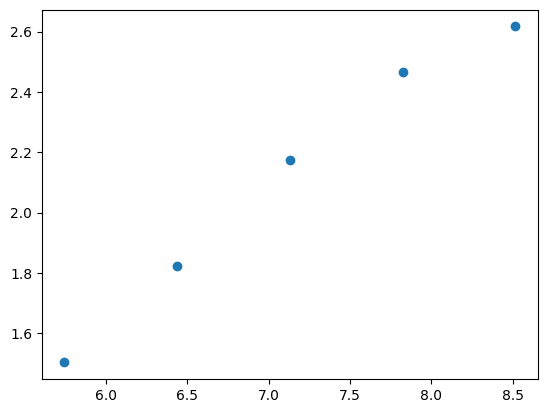

In [440]:
poly_order = 1
rating = np.random.randn(10000)#rating_all[0][0]
window_sizes = [len(rating)//2,len(rating)//4,len(rating)//8,len(rating)//16,len(rating)//32]
F_n_all = []
for w in window_sizes:
    X_t = np.cumsum(np.array(rating) - np.mean(rating))
    segments = np.array_split(X_t, len(X_t)//w)
    poly_coeffs_all = []
    Y_t = []
    for i in range(len(segments)):
        poly_coeff = np.polyfit(np.arange(w), segments[i][:w], poly_order)
        poly_coeffs_all.append(poly_coeff) #slope then intercept
        Y_t_seg = poly_coeff[0]*np.arange(w)+poly_coeff[1]
        for j in range(len(Y_t_seg)):
            Y_t.append(Y_t_seg[j])
    F_n = np.sqrt(np.sum((X_t[:len(Y_t)] - np.array(Y_t))**2)/len(X_t))
    F_n_all.append(F_n)
plt.scatter(np.log(window_sizes),np.log(F_n_all))
np.polyfit(np.log(window_sizes),np.log(F_n_all),1)



In [441]:
def hurst_dfa_tryhardpls(rating):
    poly_order = 1
    rating = np.random.randn(10000)#rating_all[0][0]
    window_sizes = [len(rating)//2,len(rating)//4,len(rating)//8,len(rating)//16,len(rating)//32]
    F_n_all = []
    for w in window_sizes:
        X_t = np.cumsum(np.array(rating) - np.mean(rating))
        segments = np.array_split(X_t, len(X_t)//w)
        poly_coeffs_all = []
        Y_t = []
        for i in range(len(segments)):
            poly_coeff = np.polyfit(np.arange(w), segments[i][:w], poly_order)
            poly_coeffs_all.append(poly_coeff) #slope then intercept
            Y_t_seg = poly_coeff[0]*np.arange(w)+poly_coeff[1]
            for j in range(len(Y_t_seg)):
                Y_t.append(Y_t_seg[j])
        F_n = np.sqrt(np.sum((X_t[:len(Y_t)] - np.array(Y_t))**2)/len(X_t))
        F_n_all.append(F_n)
    #plt.scatter(np.log(window_sizes),np.log(F_n_all))
    return np.polyfit(np.log(window_sizes),np.log(F_n_all),1)





In [446]:
hurst_dfa_all_dllm = []
fractal_dfa_all_dllm = []
for i in range(len(rating_downsample_list_all)):
    hurst_dfa_list = []
    fractal_list = []
    for j in range(len(rating_downsample_list_all[i])):
        hurst_dllm = hurst_dfa_tryhardpls(rating_downsample_list_all[i][j])
        hurst_dfa_list.append(hurst_dllm[0])
        fractal_list.append(2-hurst_dllm[0])
    hurst_dfa_all_dllm.append(hurst_dfa_list)
    fractal_dfa_all_dllm.append(fractal_list)


Text(0.5, 0, 'Fractal Dimension Value')

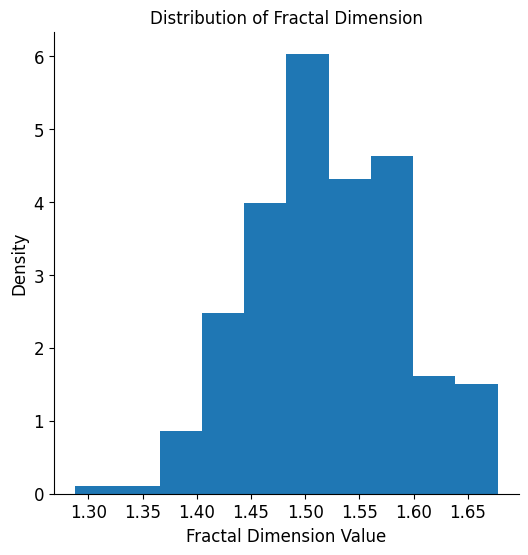

In [608]:
plt.rcParams['figure.figsize'] = (6,6)
fractal_dfa_all_dllm_flatten = []
fig, ax = plt.subplots()
for i in range(len(fractal_dfa_all_dllm)):
    for j in range(len(fractal_dfa_all_dllm[i])):
        fractal_dfa_all_dllm_flatten.append(fractal_dfa_all_dllm[i][j])
ax.hist(fractal_dfa_all_dllm_flatten, density = True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Distribution of Fractal Dimension')
ax.set_ylabel('Density')
ax.set_xlabel('Fractal Dimension Value')

In [390]:
def hurst_dfa_blog(price, min_lag=2, max_lag=100):
  lags = np.arange(min_lag, max_lag + 1)
  tau = [np.std(np.subtract(price[lag:], price[:-lag])) 
    for lag in lags]
  m = np.polyfit(np.log10(lags), np.log10(tau), 1)
  return m, lags, tau

In [368]:
def hurst_dfa(ratings):
  dfa_list = []
  for i in range(len(ratings)):
    dfa_list.append(ent.detrended_fluctuation(ratings[i]))
  return dfa_list

In [398]:
fractal_dfa_list = []
for i in tqdm(range(len(rating_downsample_list_all))):
    fractal_dfa_part = []
    for j in range(len(rating_downsample_list_all[i])):
        m, lags, tau = hurst_dfa_blog(rating_downsample_list_all[i][j])
        fractal_dfa_part.append(2-np.array(m[0]))
    fractal_dfa_list.append(fractal_dfa_part)


  0%|          | 0/79 [00:00<?, ?it/s]

In [392]:
fractal_dfa_list_ent = []
for i in tqdm(range(len(rating_downsample_list_all))):
    for j in range(len(rating_downsample_list_all[i])):
        alpha = hurst_dfa(rating_downsample_list_all[i])
    fractal_dfa_list_ent.append(np.array(alpha)-1)


  0%|          | 0/79 [00:00<?, ?it/s]

(array([ 6., 19., 23., 50., 34., 32., 33., 18., 17.,  6.]),
 array([1.19374316, 1.27289366, 1.35204416, 1.43119467, 1.51034517,
        1.58949567, 1.66864617, 1.74779668, 1.82694718, 1.90609768,
        1.98524819]),
 <BarContainer object of 10 artists>)

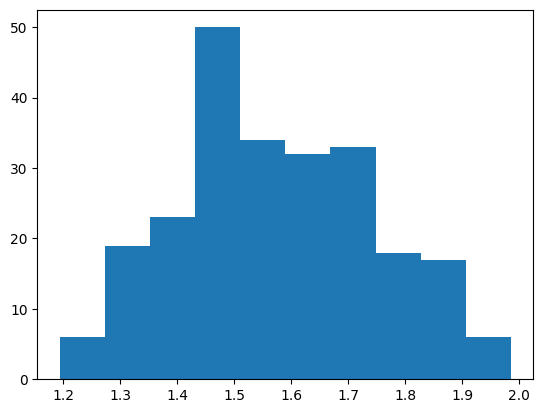

In [399]:
fractal_DFA_flatten = []
for i in range(len(fractal_dfa_list)):
    for j in range(len(fractal_dfa_list[i])):
        fractal_DFA_flatten.append(fractal_dfa_list[i][j])
plt.hist(fractal_DFA_flatten)

In [455]:
fractal_dfa_dllm_overall = []
for i in range(len(fractal_dfa_all_dllm)):
    fractal_dfa_dllm_overall.append(np.nanmean(fractal_dfa_all_dllm[i]))
print(np.nanmin(fractal_dfa_dllm_overall))
print(np.nanmax(fractal_dfa_dllm_overall))
print(np.nanmean(fractal_dfa_dllm_overall))
print(np.nanstd(fractal_dfa_dllm_overall))

1.4085569397670026
1.5985007148043273
1.5212309580266365
0.04352340751516006


C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\2708337468.py:3: RuntimeWarning: Mean of empty slice
  fractal_dfa_dllm_overall.append(np.nanmean(fractal_dfa_all_dllm[i]))


In [197]:
mean_list_all = []
mean_square_list_all = []
rms_list_all = []
variance_list_all = []
std_list_all = []

for j in range(len(rating_downsample_list_all)):
    mean_list = mean(rating_downsample_list_all[j])
    mean_square_list = mean_square(rating_downsample_list_all[j], time_downsample_list_all[j])
    rms_list = rms(mean_square_list)
    variance_list= variance(rating_downsample_list_all[j], time_downsample_list_all[j])
    std_list = std(variance_list)
    mean_list_all.append(mean_list)
    mean_square_list_all.append(mean_square_list)
    rms_list_all.append(rms_list)
    variance_list_all.append(variance_list)
    std_list_all.append(std_list)
mean_overall = []
for i in range(len(mean_list_all)):
    mean_overall.append(np.mean(mean_list_all[i]))
def var_all(rating):
    if len(rating) == 1:
        rating_collected = rating[0]
    elif len(rating) == 2:
        rating_collected = np.hstack([rating[0], rating[1]])
    elif len(rating) == 3:
        rating_collected = np.hstack([rating[0], rating[1], rating[2]])
    elif len(rating) == 4:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3]])
    elif len(rating) == 5:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3], rating[4]])
    else: 
        rating_collected = np.nan
    return np.var(rating_collected)
var_combined_list_all = []
for j in range(len(rating_downsample_list_all)):
    var_combined_list = var_all(rating_downsample_list_all[j])
    var_combined_list_all.append(var_combined_list)



# Correlation with Fractal Dimension

In [560]:
#list all the data files and its path
questionnaire = []
onlyfiles = [f for f in listdir('../Data/questionnaire') if isfile(join('../Data/questionnaire', f))]
for i in range(len(onlyfiles)):
    path = '../Data/questionnaire/' + onlyfiles[i]
    questionnaire.append(path)

questionnaire

df_questionnaire_pre = pd.read_csv(questionnaire[0])
df_questionnaire_s1 = pd.read_csv(questionnaire[1])
df_questionnaire_s2 = pd.read_csv(questionnaire[2])
index_pre = []
for id in participant_list:
    index_pre.append(np.where(df_questionnaire_pre.PROLIFIC_PID == id)[0][0])
index_s1 = []
for id in participant_list:
    index_s1.append(np.where(df_questionnaire_s1.PROLIFIC_PID == id)[0])
index_s2 = []
for id in participant_list:
    index_s2.append(np.where(df_questionnaire_s2.PROLIFIC_PID == id)[0])
df_questionnaire_index_pre = df_questionnaire_pre.iloc[index_pre]
msk_scores = df_questionnaire_index_pre['Score'].values

[[ 1.         -0.14861415]
 [-0.14861415  1.        ]]
0.3236227201303578


Text(0.5, 1.0, 'MSK scores against fractal dimension')

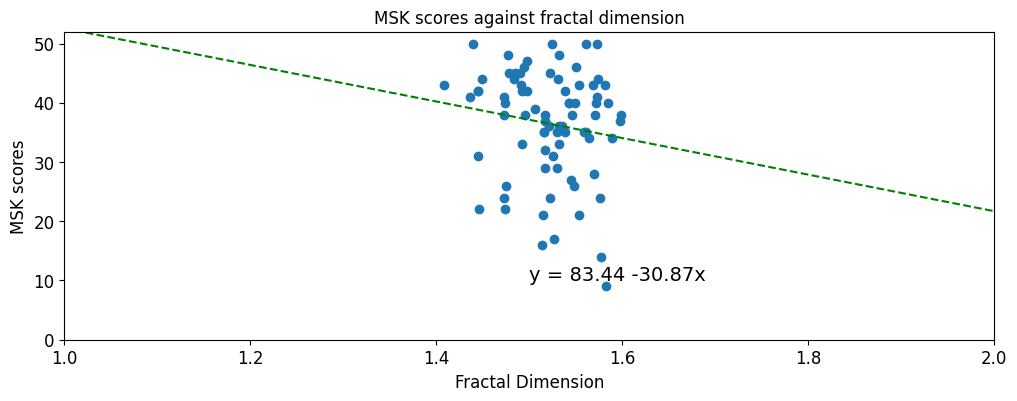

In [581]:
fractal_mskscores = zip(fractal_dfa_dllm_overall, msk_scores)
x = []; y=[]
for point in list(fractal_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores = np.corrcoef(x,y)
print(corr_fractal_mskscores)
fractal_bf_dfa = []
bf_fractal_msk = pingouin.bayesfactor_pearson(corr_fractal_mskscores[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_msk)
print(bf_fractal_msk)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('MSK scores')
plt.xlim(1,2)
plt.ylim(0,52)
plt.text(1.5, 10, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('MSK scores against fractal dimension')

[[ 1.         -0.15647398]
 [-0.15647398  1.        ]]
0.35444478403220275


Text(0.5, 1.0, 'No. of Physically Active Days against fractal dimension')

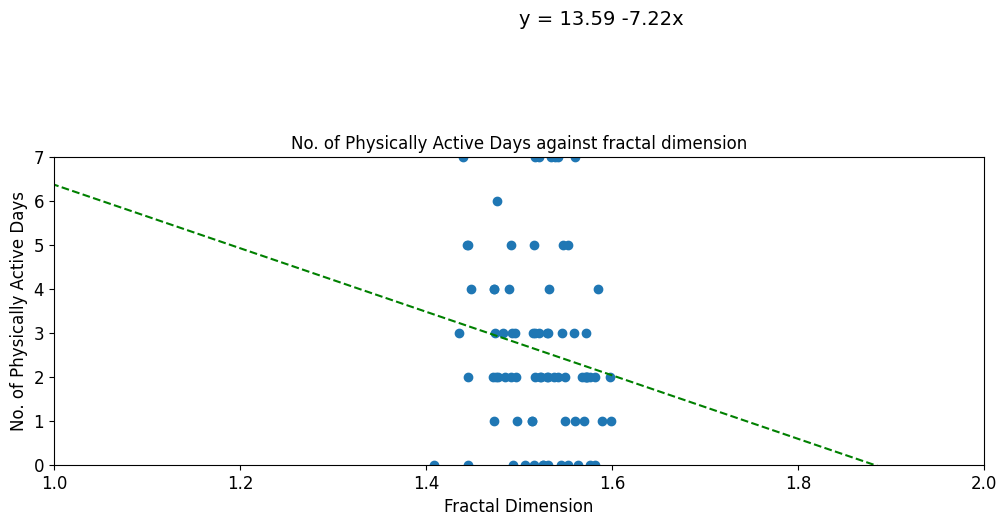

In [582]:
msk_lastq = np.load('msk_last_q.npy')
fractal_mskscores_lastq = zip(fractal_dfa_dllm_overall, msk_lastq)
x = []; y=[]
for point in list(fractal_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores_lastq = np.corrcoef(x,y)
print(corr_fractal_mskscores_lastq)
fractal_bf_dfa = []
bf_fractal_msk_lastq = pingouin.bayesfactor_pearson(corr_fractal_mskscores_lastq[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_msk_lastq)
print(bf_fractal_msk_lastq)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('No. of Physically Active Days')
plt.xlim(1,2)
plt.ylim(0,7)
plt.text(1.5, 10, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('No. of Physically Active Days against fractal dimension')


[[1.         0.05266543]
 [0.05266543 1.        ]]
0.15679053576416657


Text(0.5, 1.0, 'Mean against fractal dimension')

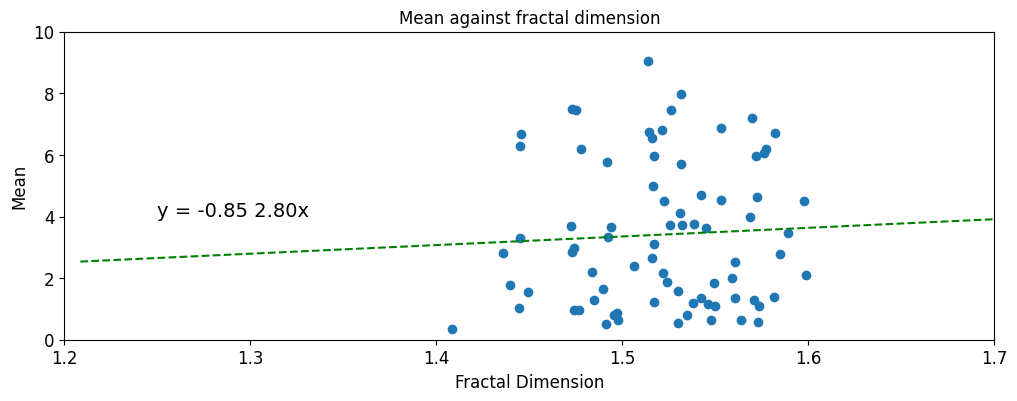

In [583]:
fractal_mean = zip(fractal_dfa_dllm_overall, mean_overall)
x = []; y=[]
for point in list(fractal_mean):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_dfa_dllm_overall)-0.2,max(fractal_dfa_dllm_overall)+0.2,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mean = np.corrcoef(x,y)
print(corr_fractal_mean)
bf_fractal_mean = pingouin.bayesfactor_pearson(corr_fractal_mean[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_mean)
print(bf_fractal_mean)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('Mean')
plt.xlim(1.2,1.7)
plt.ylim(0,10)
plt.text(1.25, 4, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('Mean against fractal dimension')

[[ 1.         -0.15272669]
 [-0.15272669  1.        ]]
0.3391921509665826


Text(0.5, 1.0, 'Variance against fractal dimension')

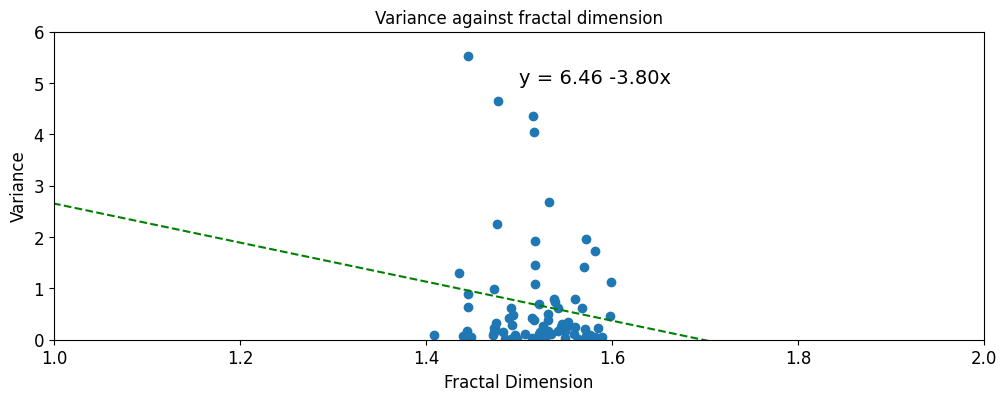

In [584]:
fractal_var = zip(fractal_dfa_dllm_overall, var_combined_list_all)
x = []; y=[]
for point in list(fractal_var):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_var = np.corrcoef(x,y)
print(corr_fractal_var)
bf_fractal_var = pingouin.bayesfactor_pearson(corr_fractal_var[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_var)
print(bf_fractal_var)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('Variance')
plt.xlim(1,2)
plt.ylim(0,6)
plt.text(1.5, 5, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('Variance against fractal dimension')

In [585]:
index_s1_normal = []
for i in range(len(index_s1)):
    if len(index_s1[i]) == 1:
        index_s1_normal.append(index_s1[i][0])
df_s1_normal = df_questionnaire_s1.iloc[index_s1_normal]
participant_list_s1_questionnaire = df_s1_normal.PROLIFIC_PID.values#.to_list()
s1_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s1_questionnaire:
        s1_questionnaire_index.append(i)
mean_s1 = np.array(mean_overall)[s1_questionnaire_index]
var_s1 = np.array(var_combined_list_all)[s1_questionnaire_index]
fractal_s1 = np.array(fractal_dfa_dllm_overall)[s1_questionnaire_index]

[[1.         0.01870245]
 [0.01870245 1.        ]]
0.15536851431134033


Text(0.5, 1.0, 'BPI mean severity score against fractal dimension')

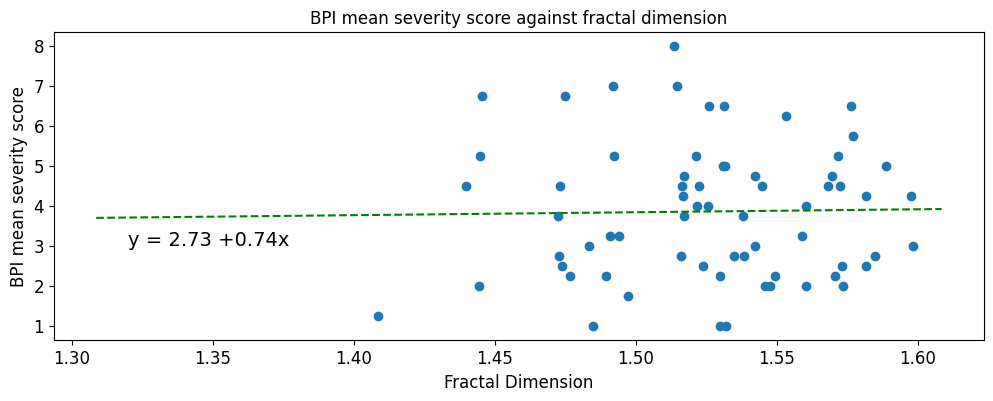

In [586]:
bpi_mean_severity = df_s1_normal['BPI Mean Severity Score'].values
fractal_bpisev = zip(fractal_s1, bpi_mean_severity)
x = []; y=[]
for point in list(fractal_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpisev = np.corrcoef(x,y)
print(corr_fractal_bpisev)
bf_fractal_bpisev = pingouin.bayesfactor_pearson(corr_fractal_bpisev[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_bpisev)
print(bf_fractal_bpisev)
x_bestfit = np.arange(min(fractal_s1-0.1),max(fractal_s1)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('BPI mean severity score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.32, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('BPI mean severity score against fractal dimension')

[[1.         0.11636023]
 [0.11636023 1.        ]]
0.23472778216287896


Text(0.5, 1.0, 'BPI mean Interference score against fractal dimension')

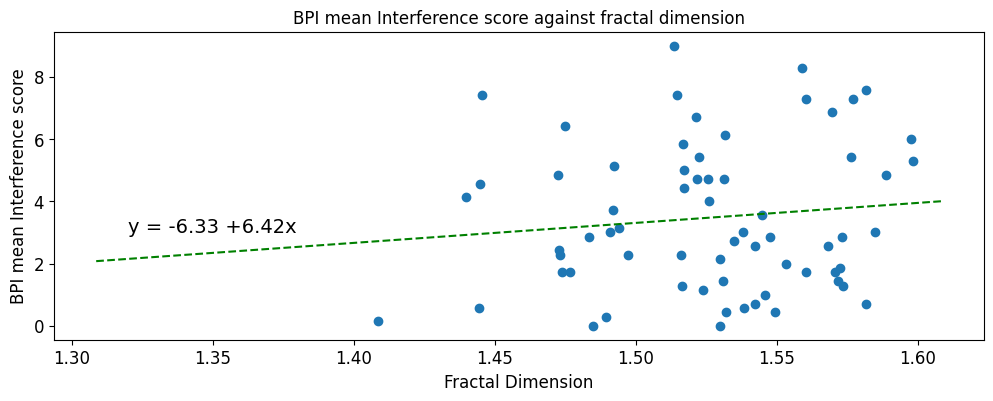

In [587]:
bpi_mean_interference = df_s1_normal['BPI Mean Pain Interference Score'].values
fractal_bpiint = zip(fractal_s1, bpi_mean_interference)
x = []; y=[]
for point in list(fractal_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpiint = np.corrcoef(x,y)
print(corr_fractal_bpiint)
bf_fractal_bpiint = pingouin.bayesfactor_pearson(corr_fractal_bpiint[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_bpiint)
print(bf_fractal_bpiint)
x_bestfit = np.arange(min(fractal_s1)-0.1,max(fractal_s1)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('BPI mean Interference score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.32, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('BPI mean Interference score against fractal dimension')

[[ 1.         -0.24535493]
 [-0.24535493  1.        ]]
0.6672994648819559


Text(0.5, 1.0, 'START total score against fractal dimension')

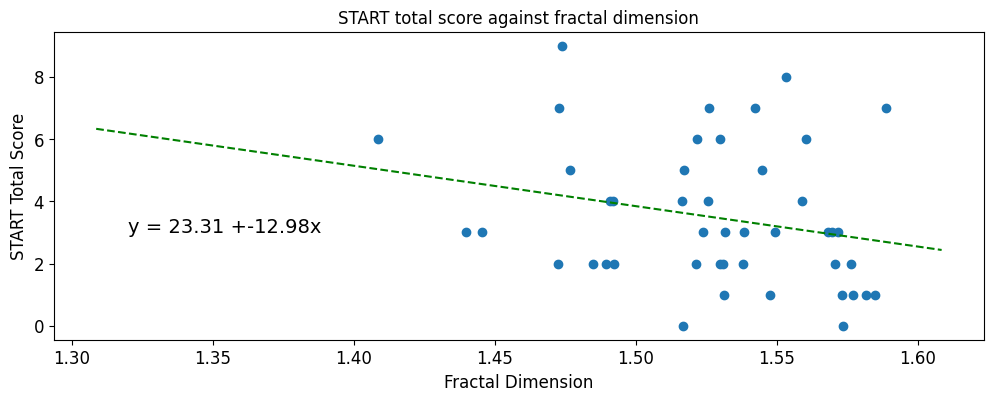

In [588]:
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_total = df_s1_normal['START total score'].iloc[back_pain].values
fractal_start = zip(fractal_s1, start_total)
x = []; y=[]
for point in list(fractal_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_start = np.corrcoef(x,y)
print(corr_fractal_start)
bf_fractal_start = pingouin.bayesfactor_pearson(corr_fractal_start[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_start)
print(bf_fractal_start)
x_bestfit = np.arange(min(fractal_s1)-0.1,max(fractal_s1)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('START Total Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.32, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('START total score against fractal dimension')

[[ 1.         -0.26780019]
 [-0.26780019  1.        ]]
0.860184753010083


Text(0.5, 1.0, 'START Sub score against fractal dimension')

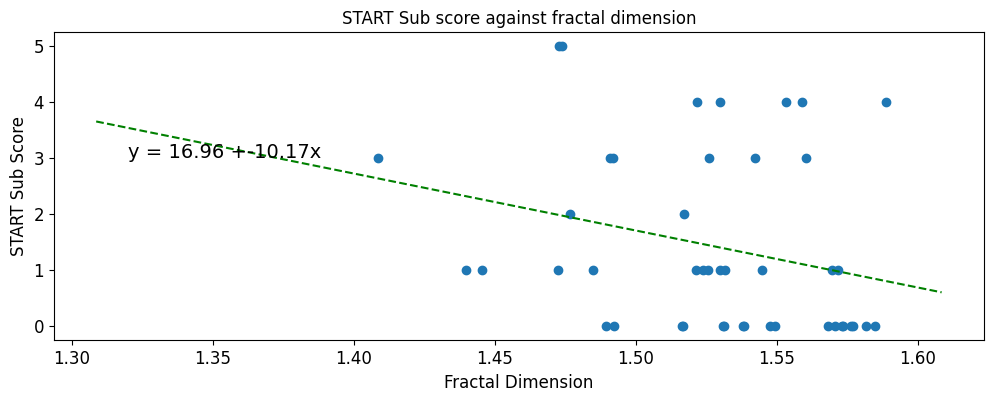

In [589]:
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_sub = df_s1_normal['START sub score'].iloc[back_pain].values
fractal_startsub = zip(fractal_s1, start_sub)
x = []; y=[]
for point in list(fractal_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_startsub = np.corrcoef(x,y)
print(corr_fractal_startsub)
bf_fractal_startsub = pingouin.bayesfactor_pearson(corr_fractal_startsub[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_startsub)
print(bf_fractal_startsub)
x_bestfit = np.arange(min(fractal_s1)-0.1,max(fractal_s1)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('START Sub Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.32, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('START Sub score against fractal dimension')

In [590]:
index_s2_normal = []
for i in range(len(index_s2)):
    if len(index_s2[i]) == 1:
        index_s2_normal.append(index_s2[i][0])
df_s2_normal = df_questionnaire_s2.iloc[index_s2_normal]
participant_list_s2_questionnaire = df_s2_normal.PROLIFIC_PID.values#.to_list()
s2_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s2_questionnaire:
        s2_questionnaire_index.append(i)
mean_s2 = np.array(mean_overall)[s2_questionnaire_index]
var_s2 = np.array(var_combined_list_all)[s2_questionnaire_index]
fractal_s2 = np.array(fractal_dfa_dllm_overall)[s2_questionnaire_index]

[[1.         0.18146763]
 [0.18146763 1.        ]]
0.41600133723632116


Text(0.5, 1.0, 'PCS Total Score against Fractal Dimension')

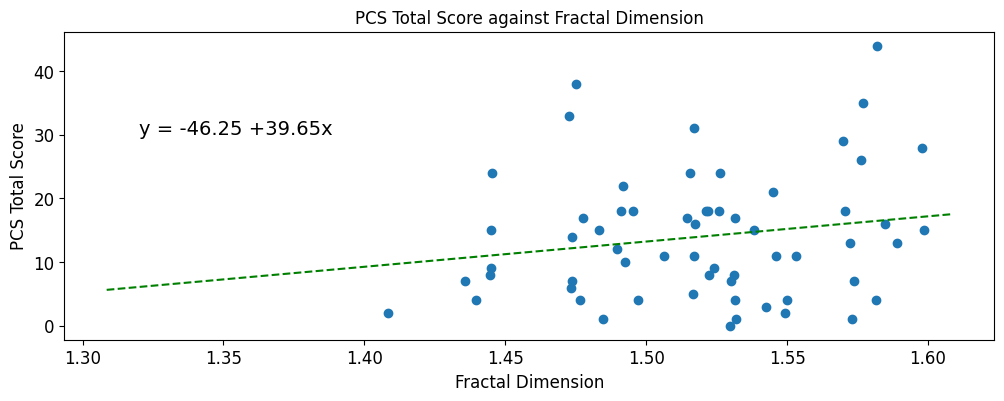

In [591]:
pcs_total = df_s2_normal['Total PCS Score'].values
fractal_pcs_total = zip(fractal_s2, pcs_total)
x = []; y=[]
for point in list(fractal_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_total = np.corrcoef(x,y)
print(corr_fractal_pcs_total)
bf_fractal_pcs_total = pingouin.bayesfactor_pearson(corr_fractal_pcs_total[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_pcs_total)
print(bf_fractal_pcs_total)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_s2)-0.1,max(fractal_s2)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Total Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.32, 30, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Total Score against Fractal Dimension')


[[1.         0.12137676]
 [0.12137676 1.        ]]
0.24382769754092695


Text(0.5, 1.0, 'PCS Rumination Score against Fractal Dimension')

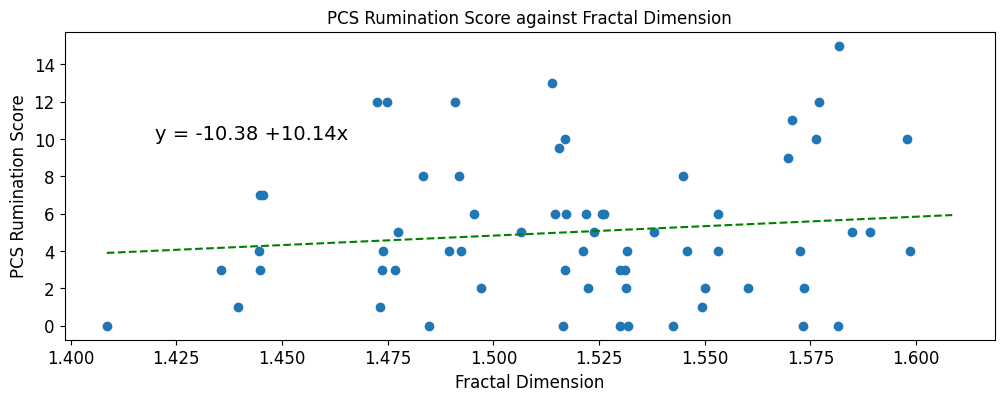

In [592]:
pcs_rum = df_s2_normal['PCS Rumination Score'].values
fractal_pcs_rum = zip(fractal_s2, pcs_rum)
x = []; y=[]
for point in list(fractal_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_rum = np.corrcoef(x,y)
print(corr_fractal_pcs_rum)
bf_fractal_pcs_rum = pingouin.bayesfactor_pearson(corr_fractal_pcs_rum[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_pcs_rum)
print(bf_fractal_pcs_rum)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_s2),max(fractal_s2)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Rumination Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.42, 10, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Rumination Score against Fractal Dimension')


[[1.         0.05614616]
 [0.05614616 1.        ]]
0.17266821151255068


Text(0.5, 1.0, 'PCS Magnification Score against Fractal Dimension')

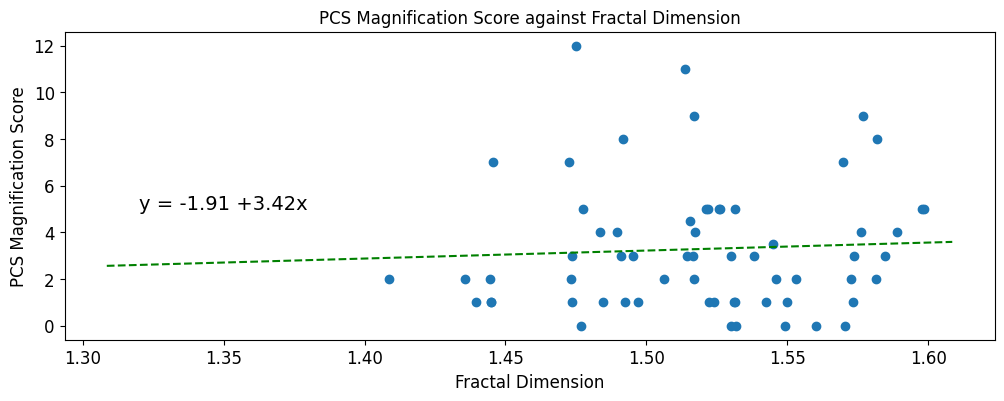

In [593]:
pcs_mag = df_s2_normal['PCS Magnification Score'].values
fractal_pcs_mag = zip(fractal_s2, pcs_mag)
x = []; y=[]
for point in list(fractal_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_mag = np.corrcoef(x,y)
print(corr_fractal_pcs_mag)
bf_fractal_pcs_mag = pingouin.bayesfactor_pearson(corr_fractal_pcs_mag[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_pcs_mag)
print(bf_fractal_pcs_mag)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_s2)-0.1,max(fractal_s2)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Magnification Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.32, 5, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Magnification Score against Fractal Dimension')

[[1.         0.22394624]
 [0.22394624 1.        ]]
0.707422216226362


Text(0.5, 1.0, 'PCS Helplessness Score against Fractal Dimension')

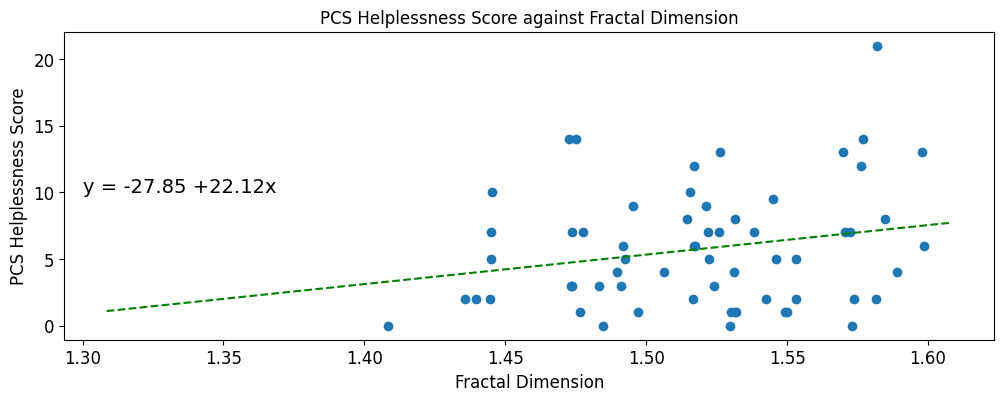

In [594]:
pcs_help = df_s2_normal['PCS Helplessness Score'].values
fractal_pcs_help = zip(fractal_s2, pcs_help)
x = []; y=[]
for point in list(fractal_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_help = np.corrcoef(x,y)
print(corr_fractal_pcs_help)
bf_fractal_pcs_help = pingouin.bayesfactor_pearson(corr_fractal_pcs_help[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_pcs_help)
print(bf_fractal_pcs_help)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_s2)-0.1,max(fractal_s2)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Helplessness Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.3, 10, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Helplessness Score against Fractal Dimension')

[[ 1.         -0.06960333]
 [-0.06960333  1.        ]]
0.18256816492624184


Text(0.5, 1.0, 'GAD7 Score against Fractal Dimension')

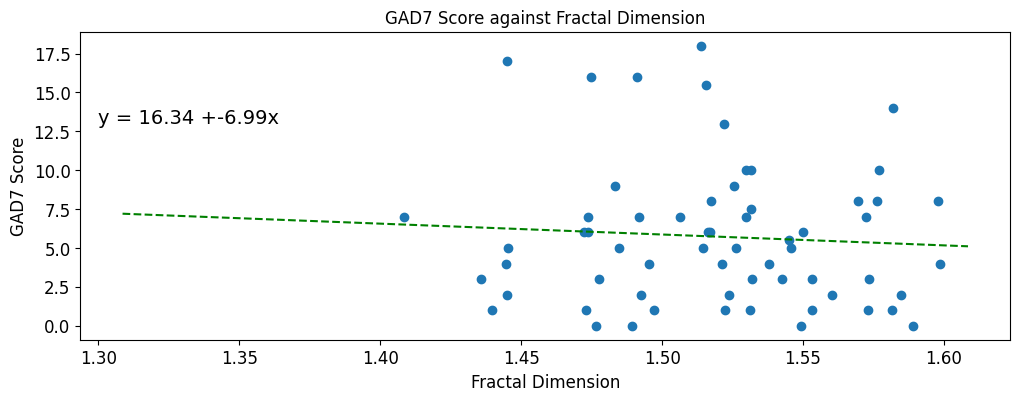

In [595]:
gad7_total = df_s2_normal['Total GAD7 Score'].values
fractal_gad7 = zip(fractal_s2, gad7_total)
x = []; y=[]
for point in list(fractal_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_gad7 = np.corrcoef(x,y)
print(corr_fractal_gad7)
bf_fractal_gad7 = pingouin.bayesfactor_pearson(corr_fractal_gad7[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_gad7)
print(bf_fractal_gad7)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_s2)-0.1,max(fractal_s2)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('GAD7 Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.3, 13, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('GAD7 Score against Fractal Dimension')

[[ 1.         -0.09441298]
 [-0.09441298  1.        ]]
0.20494979302166422


Text(0.5, 1.0, 'PHQ9 Score against Fractal Dimension')

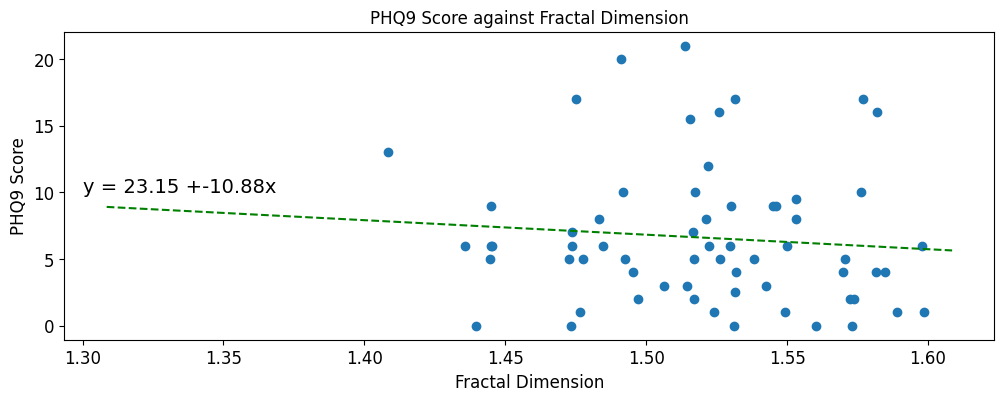

In [596]:
phq9_total = df_s2_normal['Total PHQ9 Score'].values
fractal_phq9 = zip(fractal_s2, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_phq9)
print(bf_fractal_phq9)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_s2)-0.1,max(fractal_s2)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PHQ9 Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.3, 10, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PHQ9 Score against Fractal Dimension')

[[ 1.         -0.09441298]
 [-0.09441298  1.        ]]
0.20494979302166422


Text(0.5, 1.0, 'PHQ9 Score against Fractal Dimension')

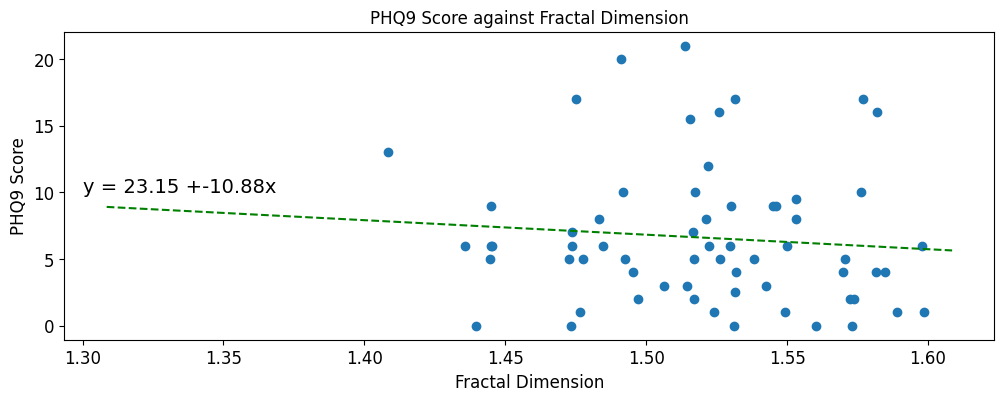

In [597]:
phq9_total = df_s2_normal['Total PHQ9 Score'].values
fractal_phq9 = zip(fractal_s2, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
fractal_bf_dfa.append(bf_fractal_phq9)
print(bf_fractal_phq9)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(min(fractal_s2)-0.1,max(fractal_s2)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PHQ9 Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.3, 10, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PHQ9 Score against Fractal Dimension')

In [598]:
np.save('fractal_corr.npy', fractal_bf_dfa)

## don't separate!

array([5.12835446, 5.12835446, 5.12835446, ..., 2.26084239, 2.26084239,
       2.26084239])

In [602]:
mean_list_all = []

variance_list_all = []


for j in range(len(rating_all)):
    mean_list = mean(rating_all[j])

    variance_list= variance(rating_all[j], timing_all[j])
    mean_list_all.append(mean_list)
    variance_list_all.append(variance_list)
mean_s1 = np.array(mean_list_all)[s1_questionnaire_index]
var_s1 = np.array(variance_list_all)[s1_questionnaire_index]
fractal_s1 = np.array(fractal_dfa_all_dllm)[s1_questionnaire_index]
index_s2_normal = []
for i in range(len(index_s2)):
    if len(index_s2[i]) == 1:
        index_s2_normal.append(index_s2[i][0])
df_s2_normal = df_questionnaire_s2.iloc[index_s2_normal]
participant_list_s2_questionnaire = df_s2_normal.PROLIFIC_PID.values#.to_list()
s2_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s2_questionnaire:
        s2_questionnaire_index.append(i)
mean_s2 = np.array(mean_list_all)[s2_questionnaire_index]
var_s2 = np.array(variance_list_all)[s2_questionnaire_index]
fractal_s2 = np.array(fractal_dfa_all_dllm)[s2_questionnaire_index]
msk_scores_lastq = np.load('msk_last_q.npy')

C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\1526891370.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_s1 = np.array(mean_list_all)[s1_questionnaire_index]
C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\1526891370.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var_s1 = np.array(variance_list_all)[s1_questionnaire_index]
C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\1526891370.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

In [603]:
print('msk scores')
fractal_mskscores = zip(fractal_dfa_all_dllm, msk_scores)
x = []; y=[]
for point in list(fractal_mskscores):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores = np.corrcoef(x,y)
print(corr_fractal_mskscores)
fractal_bf_RS = []
bf_fractal_msk = pingouin.bayesfactor_pearson(corr_fractal_mskscores[0][1], len(x))
fractal_bf_RS.append(bf_fractal_msk)
print(bf_fractal_msk)

print('------')
print('no of active days')
fractal_mskscores_lastq = zip(fractal_dfa_all_dllm, msk_scores_lastq)
x = []; y=[]
for point in list(fractal_mskscores_lastq):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores_lastq = np.corrcoef(x,y)
print(corr_fractal_mskscores_lastq)
bf_fractal_msk_lastq = pingouin.bayesfactor_pearson(corr_fractal_mskscores_lastq[0][1], len(x))
fractal_bf_RS.append(bf_fractal_msk_lastq)
print(bf_fractal_msk_lastq)

print('------')
print('mean')
fractal_mean = zip(fractal_dfa_all_dllm, mean_list_all)
x = []; y=[]
for point in list(fractal_mean):
   for i in range(len(point[0])):
      if len(point[0]) == len(point[1]):
         x.append(point[0][i])
         y.append(point[1][i])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mean = np.corrcoef(x,y)
print(corr_fractal_mean)
bf_fractal_mean = pingouin.bayesfactor_pearson(corr_fractal_mean[0][1], len(x))
fractal_bf_RS.append(bf_fractal_mean)
print(bf_fractal_mean)


print('------')
print('variance')
fractal_var = zip(fractal_dfa_all_dllm, variance_list_all)
x = []; y=[]
for point in list(fractal_var):
   for i in range(len(point[0])):
      if len(point[0]) == len(point[1]):
         x.append(point[0][i])
         y.append(point[1][i])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_var = np.corrcoef(x,y)
print(corr_fractal_var)
bf_fractal_var = pingouin.bayesfactor_pearson(corr_fractal_var[0][1], len(x))
fractal_bf_RS.append(bf_fractal_var)
print(bf_fractal_var)

print('------')
print('BPI mean severity')
bpi_mean_severity = df_s1_normal['BPI Mean Severity Score'].values
fractal_bpisev = zip(fractal_s1, bpi_mean_severity)
x = []; y=[]
for point in list(fractal_bpisev):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpisev = np.corrcoef(x,y)
print(corr_fractal_bpisev)
bf_fractal_bpisev = pingouin.bayesfactor_pearson(corr_fractal_bpisev[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpisev)
print(bf_fractal_bpisev)

print('------')
print('BPI mean interference')
bpi_mean_interference = df_s1_normal['BPI Mean Pain Interference Score'].values
fractal_bpiint = zip(fractal_s1, bpi_mean_interference)
x = []; y=[]
for point in list(fractal_bpiint):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpiint = np.corrcoef(x,y)
print(corr_fractal_bpiint)
bf_fractal_bpiint = pingouin.bayesfactor_pearson(corr_fractal_bpiint[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpiint)
print(bf_fractal_bpiint)


print('------')
print('start')
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_total = df_s1_normal['START total score'].iloc[back_pain].values
fractal_start = zip(fractal_s1, start_total)
x = []; y=[]
for point in list(fractal_start):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_start = np.corrcoef(x,y)
print(corr_fractal_start)
bf_fractal_start = pingouin.bayesfactor_pearson(corr_fractal_start[0][1], len(x))
fractal_bf_RS.append(bf_fractal_start)
print(bf_fractal_start)


print('------')
print('startsub')
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_sub = df_s1_normal['START sub score'].iloc[back_pain].values
fractal_startsub = zip(fractal_s1, start_sub)
x = []; y=[]
for point in list(fractal_startsub):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_startsub = np.corrcoef(x,y)
print(corr_fractal_startsub)
bf_fractal_startsub = pingouin.bayesfactor_pearson(corr_fractal_startsub[0][1], len(x))
fractal_bf_RS.append(bf_fractal_startsub)
print(bf_fractal_startsub)


print('------')
print('PCS')
pcs_total = df_s2_normal['Total PCS Score'].values
fractal_pcs_total = zip(fractal_s2, pcs_total)
x = []; y=[]
for point in list(fractal_pcs_total):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_total = np.corrcoef(x,y)
print(corr_fractal_pcs_total)
bf_fractal_pcs_total = pingouin.bayesfactor_pearson(corr_fractal_pcs_total[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_total)
print(bf_fractal_pcs_total)


print('------')
print('PCS rum')
pcs_rum = df_s2_normal['PCS Rumination Score'].values
fractal_pcs_rum = zip(fractal_s2, pcs_rum)
x = []; y=[]
for point in list(fractal_pcs_rum):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_rum = np.corrcoef(x,y)
print(corr_fractal_pcs_rum)
bf_fractal_pcs_rum = pingouin.bayesfactor_pearson(corr_fractal_pcs_rum[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_rum)
print(bf_fractal_pcs_rum)


print('------')
print('PCS mag')
pcs_mag = df_s2_normal['PCS Magnification Score'].values
fractal_pcs_mag = zip(fractal_s2, pcs_mag)
x = []; y=[]
for point in list(fractal_pcs_mag):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_mag = np.corrcoef(x,y)
print(corr_fractal_pcs_mag)
bf_fractal_pcs_mag = pingouin.bayesfactor_pearson(corr_fractal_pcs_mag[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_mag)
print(bf_fractal_pcs_mag)


print('------')
print('PCS help')
pcs_help = df_s2_normal['PCS Helplessness Score'].values
fractal_pcs_help = zip(fractal_s2, pcs_help)
x = []; y=[]
for point in list(fractal_pcs_help):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_help = np.corrcoef(x,y)
print(corr_fractal_pcs_help)
bf_fractal_pcs_help = pingouin.bayesfactor_pearson(corr_fractal_pcs_help[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_help)
print(bf_fractal_pcs_help)


print('------')
print('gad7')
gad7_total = df_s2_normal['Total GAD7 Score'].values
fractal_gad7 = zip(fractal_s2, gad7_total)
x = []; y=[]
for point in list(fractal_gad7):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_gad7 = np.corrcoef(x,y)
print(corr_fractal_gad7)
bf_fractal_gad7 = pingouin.bayesfactor_pearson(corr_fractal_gad7[0][1], len(x))
fractal_bf_RS.append(bf_fractal_gad7)
print(bf_fractal_gad7)

print('------')
print('phq9')
phq9_total = df_s2_normal['Total PHQ9 Score'].values
fractal_phq9 = zip(fractal_s2, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
fractal_bf_RS.append(bf_fractal_phq9)
print(bf_fractal_phq9)
if np.max(fractal_bf_RS) > 1:
   print('True')
else:
   print('False')



msk scores
[[ 1.         -0.09126418]
 [-0.09126418  1.        ]]
0.21596337084737535
------
no of active days
[[ 1.        -0.0914057]
 [-0.0914057  1.       ]]
0.21662317033293915
------
mean
[[1.         0.02901401]
 [0.02901401 1.        ]]
0.08956013132019412
------
variance
[[ 1.        -0.0918094]
 [-0.0918094  1.       ]]
0.21852223155612904
------
BPI mean severity
[[1.         0.01540461]
 [0.01540461 1.        ]]
0.09016813529670309
------
BPI mean interference
[[1.         0.06443238]
 [0.06443238 1.        ]]
0.132970050616782
------
start
[[ 1.         -0.16973988]
 [-0.16973988  1.        ]]
0.7475349799195512
------
startsub
[[ 1.         -0.18486716]
 [-0.18486716  1.        ]]
1.0806065756618688
------
PCS
[[1.         0.12015279]
 [0.12015279 1.        ]]
0.34639664738602094
------
PCS rum
[[1.         0.08471014]
 [0.08471014 1.        ]]
0.17871635021253046
------
PCS mag
[[1.         0.03772643]
 [0.03772643 1.        ]]
0.10308306624801772
------
PCS help
[[1.   

In [604]:
np.save('fractal_corr_all.npy', fractal_bf_dfa)

# Rescaled Range

In [219]:
def create_ranges(data, scale_level):
    ranges = []
    #L: lenth of data
    L = len(data)
    #size of range = original range size
    ranges.append(data.reshape((1,L)))
    
    for i in scale_level:
        #step 2
        range_i = np.zeros((i,L//i))
        for j in range(i):
            range_i[j] = data[j*(L//i):(j+1)*(L//i)]
        ranges.append(range_i)
    
    return ranges

In [222]:
import scipy.stats

In [301]:
def RS_hurst(rating):
    
    scale_level = np.array([2,4,8,16,32,64,128])
    hurst_list = []
    for i in range(len(rating)):
        data = rating[i]
        L = len(data)

        ranges_test = create_ranges(data, scale_level)
        #step 3, 4
        ranges_zero_mean = []
        for i in range(len(ranges_test)):
            ranges_zero_mean.append((ranges_test[i].T - np.mean(ranges_test[i],axis = 1)).T)
        #step 5 (not very efficient)
        cumulative_ranges = []
        cum_range_i = np.zeros(ranges_zero_mean[0].reshape(-1).shape)
        cumulative_ranges.append(cum_range_i.reshape((1,L)))
        for p in range(L):
            cum_range_i[p] = np.sum(ranges_zero_mean[0].reshape(-1)[:p])
        for i in range(1,len(ranges_test)):
            cum_range_i = np.zeros((scale_level[i-1],L//scale_level[i-1]))
            for j in range(ranges_zero_mean[i].shape[1]):
                cum_range_i[:,j] = np.sum(ranges_zero_mean[i][:,:j], axis = 1)
            cumulative_ranges.append(cum_range_i)
        #step 6
        deviation_list = []
        deviation_list.append(np.array([np.max(cumulative_ranges[0]) - np.min(cumulative_ranges[0])]))

        for i in range(len(cumulative_ranges)-1):
            deviation_list.append(np.max(cumulative_ranges[i+1],axis = 1) - np.min(cumulative_ranges[i+1],axis = 1))
        #step 7
        variance_list = []
        variance_list.append(np.array([np.std(ranges_zero_mean[0])]))

        for i in range(len(cumulative_ranges)-1):
            variance_list.append(np.std(ranges_zero_mean[i+1],axis = 1))
        #step 8
        rescaled_range = []
        rescaled_range.append(deviation_list[0]/variance_list[0])

        for i in range(len(cumulative_ranges)-1):
            rescaled_range.append(deviation_list[i+1]/variance_list[i+1])
        rescaled_range_ave = []
        for i in range(len(cumulative_ranges)):
            rescaled_range_ave.append(np.nanmean(rescaled_range[i]))
        rescaled_range_ave = np.array(rescaled_range_ave)
        nan_position = np.argwhere(np.isnan(rescaled_range_ave)).tolist()
        inf_position = np.argwhere(np.isinf(rescaled_range_ave)).tolist()
        invalid_pos = inf_position + nan_position
        range_list = np.array([1,2,4,8,16,32,64,128])
        #plt.figure()
        #plt.scatter(np.log(L/range_list),np.log(rescaled_range_ave))
        if len(invalid_pos) == 0:
            hurst_list.append(scipy.stats.linregress(np.log(L/range_list),np.log(rescaled_range_ave))[0])
        else:
            hurst_list.append(scipy.stats.linregress(np.log(L/np.delete(range_list, invalid_pos)),np.log(np.delete(rescaled_range_ave, invalid_pos)))[0])
    return hurst_list


In [ ]:
hurst_RS_all = []
fractal_RS_all = []
for i in range(len(rating_downsample_list_all)):
    hurst_part = RS_hurst(rating_downsample_list_all[i])
    hurst_RS_all.append(hurst_part)
    fractal_RS_all.append(2-np.array(hurst_part))

In [273]:
fractal_overall_RS = []
for i in range(len(fractal_RS_all)):
    fractal_overall_RS.append(np.nanmean(fractal_RS_all[i]))

C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\1966307814.py:3: RuntimeWarning: Mean of empty slice
  fractal_overall_RS.append(np.nanmean(fractal_RS_all[i]))


(array([  1.,   0.,   2.,   6., 101.,  92.,  22.,   6.,   2.,   1.]),
 array([0.10690143, 0.29405008, 0.48119874, 0.66834739, 0.85549605,
        1.0426447 , 1.22979336, 1.41694201, 1.60409067, 1.79123932,
        1.97838798]),
 <BarContainer object of 10 artists>)

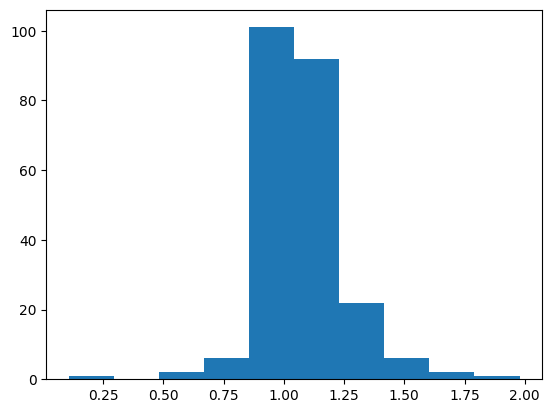

In [347]:
fractal_RS_flatten = []
for i in range(len(fractal_RS_all)):
    for j in range(len(fractal_RS_all[i])):
        fractal_RS_flatten.append(fractal_RS_all[i][j])
plt.hist(fractal_RS_flatten)

In [276]:
index_s1_normal = []
for i in range(len(index_s1)):
    if len(index_s1[i]) == 1:
        index_s1_normal.append(index_s1[i][0])
df_s1_normal = df_questionnaire_s1.iloc[index_s1_normal]
participant_list_s1_questionnaire = df_s1_normal.PROLIFIC_PID.values#.to_list()
s1_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s1_questionnaire:
        s1_questionnaire_index.append(i)
mean_s1 = np.array(mean_overall)[s1_questionnaire_index]
var_s1 = np.array(var_combined_list_all)[s1_questionnaire_index]
fractal_s1_RS = np.array(fractal_overall_RS)[s1_questionnaire_index]
index_s2_normal = []
for i in range(len(index_s2)):
    if len(index_s2[i]) == 1:
        index_s2_normal.append(index_s2[i][0])
df_s2_normal = df_questionnaire_s2.iloc[index_s2_normal]
participant_list_s2_questionnaire = df_s2_normal.PROLIFIC_PID.values#.to_list()
s2_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s2_questionnaire:
        s2_questionnaire_index.append(i)
mean_s2 = np.array(mean_overall)[s2_questionnaire_index]
var_s2 = np.array(var_combined_list_all)[s2_questionnaire_index]
fractal_s2_RS = np.array(fractal_overall_RS)[s2_questionnaire_index]

[[ 1.         -0.06087637]
 [-0.06087637  1.        ]]
0.1623200294123216
[[ 1.         -0.12287062]
 [-0.12287062  1.        ]]
0.2485620535082319
[[ 1.        -0.0738558]
 [-0.0738558  1.       ]]
0.17323856926619546
[[ 1.         -0.04464487]
 [-0.04464487  1.        ]]
0.15398129080083767
[[ 1.         -0.01287417]
 [-0.01287417  1.        ]]
0.14415187456742518
[[ 1.         -0.22738635]
 [-0.22738635  1.        ]]
0.6427937641567049
[[ 1.        -0.2100991]
 [-0.2100991  1.       ]]
0.5266947286576421
[[ 1.         -0.13273699]
 [-0.13273699  1.        ]]
0.26557367515751
[[1.         0.09445792]
 [0.09445792 1.        ]]
0.20431805458489707
[[ 1.         -0.00861956]
 [-0.00861956  1.        ]]
0.1576233245149261
[[ 1.         -0.16349001]
 [-0.16349001  1.        ]]
0.34845811259680654
[[1.         0.14928153]
 [0.14928153 1.        ]]
0.3052375806384276
[[1.         0.16021485]
 [0.16021485 1.        ]]
0.3393081224822952


Text(0.5, 1.0, 'PHQ9 Score against Fractal Dimension')

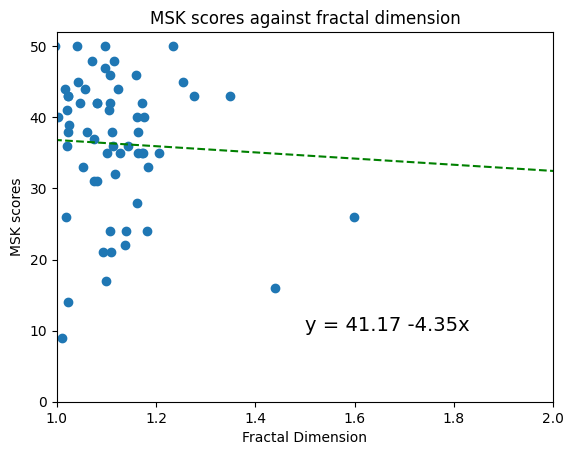

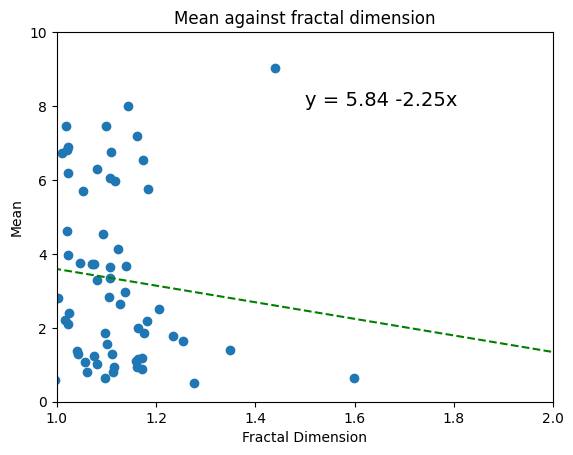

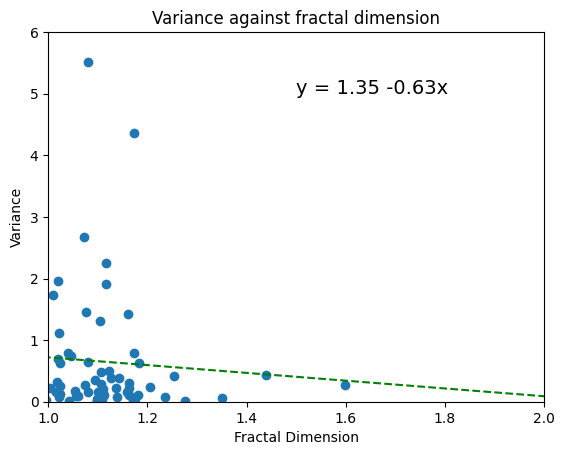

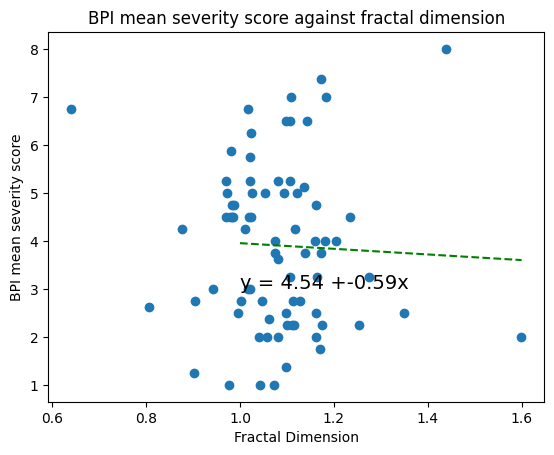

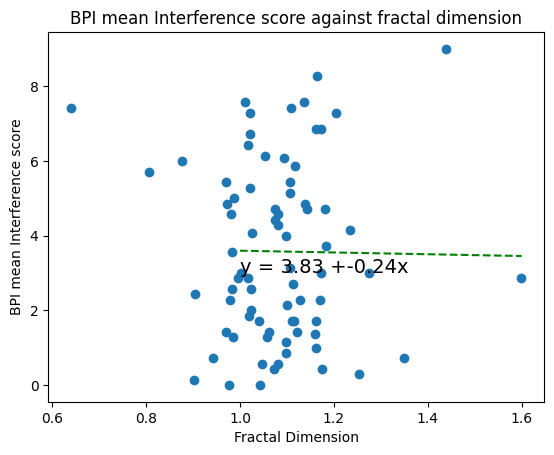

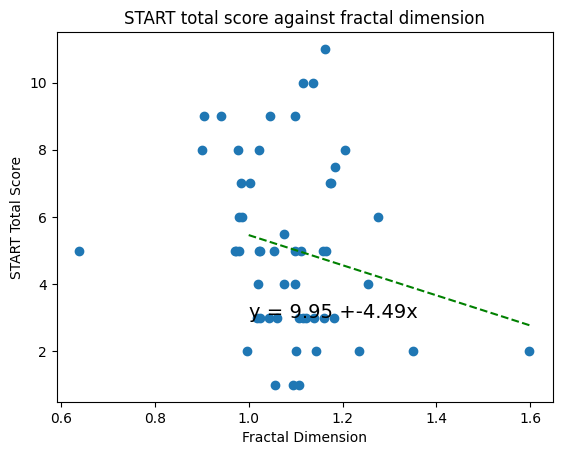

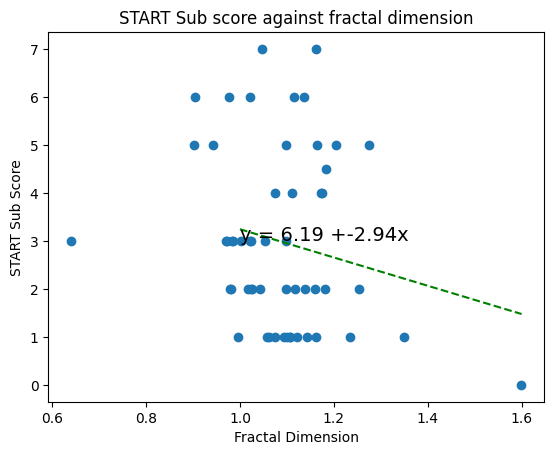

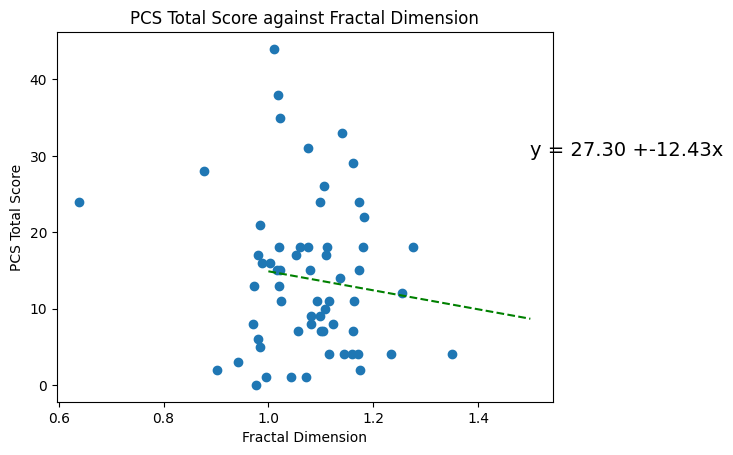

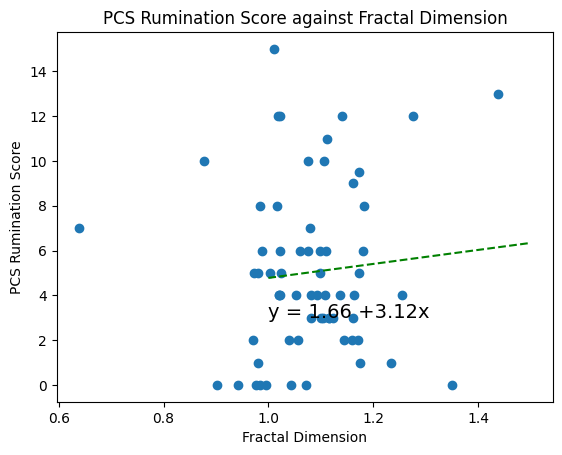

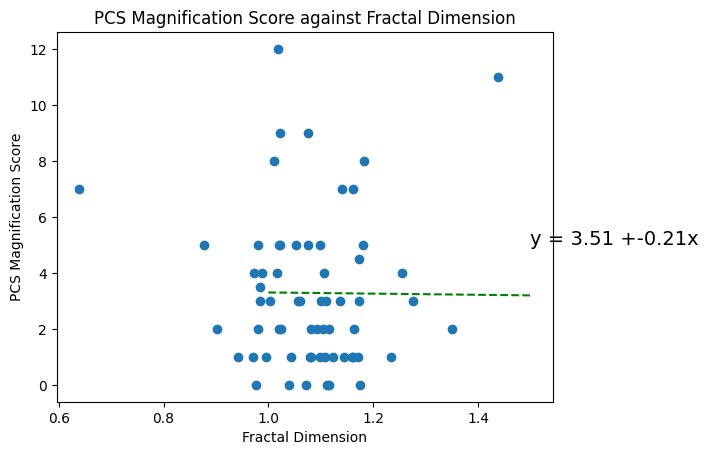

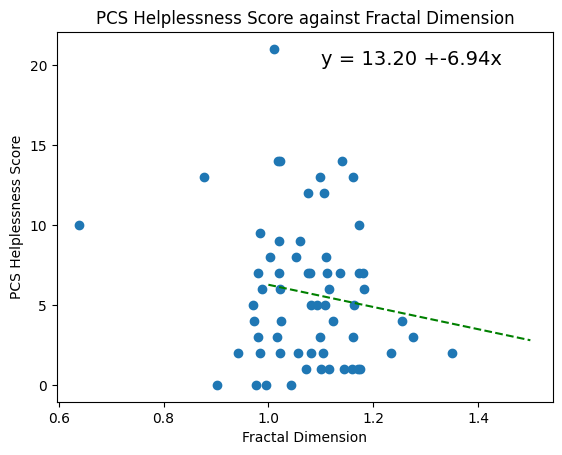

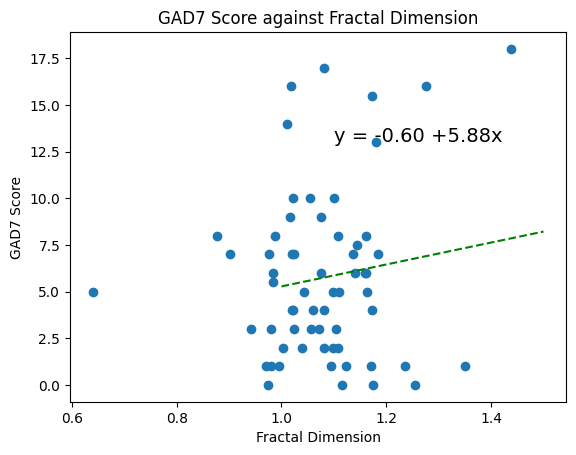

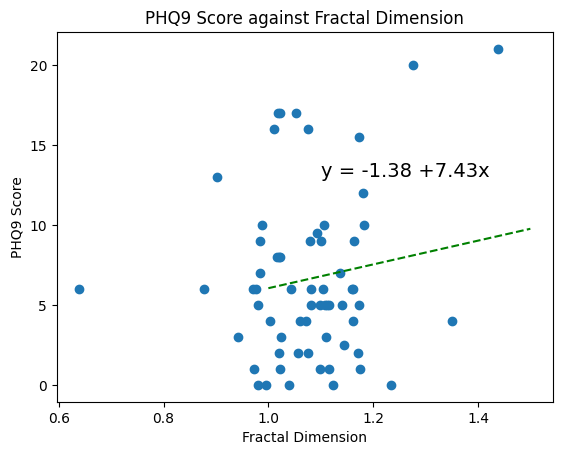

In [278]:
plt.figure()
fractal_mskscores = zip(fractal_overall_RS, msk_scores)
x = []; y=[]
for point in list(fractal_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores = np.corrcoef(x,y)
print(corr_fractal_mskscores)
fractal_bf_RS = []
bf_fractal_msk = pingouin.bayesfactor_pearson(corr_fractal_mskscores[0][1], len(x))
fractal_bf_RS.append(bf_fractal_msk)
print(bf_fractal_msk)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('MSK scores')
plt.xlim(1,2)
plt.ylim(0,52)
plt.text(1.5, 10, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('MSK scores against fractal dimension')


fractal_mean = zip(fractal_overall_RS, mean_overall)
x = []; y=[]
for point in list(fractal_mean):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mean = np.corrcoef(x,y)
print(corr_fractal_mean)
bf_fractal_mean = pingouin.bayesfactor_pearson(corr_fractal_mean[0][1], len(x))
fractal_bf_RS.append(bf_fractal_mean)
print(bf_fractal_mean)
plt.figure()
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('Mean')
plt.xlim(1,2)
plt.ylim(0,10)
plt.text(1.5, 8, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('Mean against fractal dimension')

plt.figure()
fractal_var = zip(fractal_overall_RS, var_combined_list_all)
x = []; y=[]
for point in list(fractal_var):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_var = np.corrcoef(x,y)
print(corr_fractal_var)
bf_fractal_var = pingouin.bayesfactor_pearson(corr_fractal_var[0][1], len(x))
fractal_bf_RS.append(bf_fractal_var)
print(bf_fractal_var)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('Variance')
plt.xlim(1,2)
plt.ylim(0,6)
plt.text(1.5, 5, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('Variance against fractal dimension')

plt.figure()
bpi_mean_severity = df_s1_normal['BPI Mean Severity Score'].values
fractal_bpisev = zip(fractal_s1_RS, bpi_mean_severity)
x = []; y=[]
for point in list(fractal_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpisev = np.corrcoef(x,y)
print(corr_fractal_bpisev)
bf_fractal_bpisev = pingouin.bayesfactor_pearson(corr_fractal_bpisev[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpisev)
print(bf_fractal_bpisev)
x_bestfit = np.arange(1,max(fractal_s1_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('BPI mean severity score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('BPI mean severity score against fractal dimension')

plt.figure()
bpi_mean_interference = df_s1_normal['BPI Mean Pain Interference Score'].values
fractal_bpiint = zip(fractal_s1_RS, bpi_mean_interference)
x = []; y=[]
for point in list(fractal_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpiint = np.corrcoef(x,y)
print(corr_fractal_bpiint)
bf_fractal_bpiint = pingouin.bayesfactor_pearson(corr_fractal_bpiint[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpiint)
print(bf_fractal_bpiint)
x_bestfit = np.arange(1,max(fractal_s1_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('BPI mean Interference score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('BPI mean Interference score against fractal dimension')

plt.figure()
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_total = df_s1_normal['START total score'].iloc[back_pain].values
fractal_start = zip(fractal_s1_RS, start_total)
x = []; y=[]
for point in list(fractal_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_start = np.corrcoef(x,y)
print(corr_fractal_start)
bf_fractal_start = pingouin.bayesfactor_pearson(corr_fractal_start[0][1], len(x))
fractal_bf_RS.append(bf_fractal_start)
print(bf_fractal_start)
x_bestfit = np.arange(1,max(fractal_s1_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('START Total Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('START total score against fractal dimension')

plt.figure()
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_sub = df_s1_normal['START sub score'].iloc[back_pain].values
fractal_startsub = zip(fractal_s1_RS, start_sub)
x = []; y=[]
for point in list(fractal_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_startsub = np.corrcoef(x,y)
print(corr_fractal_startsub)
bf_fractal_startsub = pingouin.bayesfactor_pearson(corr_fractal_startsub[0][1], len(x))
fractal_bf_RS.append(bf_fractal_startsub)
print(bf_fractal_startsub)
x_bestfit = np.arange(1,max(fractal_s1_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('START Sub Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('START Sub score against fractal dimension')

plt.figure()
pcs_total = df_s2_normal['Total PCS Score'].values
fractal_pcs_total = zip(fractal_s2_RS, pcs_total)
x = []; y=[]
for point in list(fractal_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_total = np.corrcoef(x,y)
print(corr_fractal_pcs_total)
bf_fractal_pcs_total = pingouin.bayesfactor_pearson(corr_fractal_pcs_total[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_total)
print(bf_fractal_pcs_total)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Total Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.5, 30, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Total Score against Fractal Dimension')

plt.figure()
pcs_rum = df_s2_normal['PCS Rumination Score'].values
fractal_pcs_rum = zip(fractal_s2_RS, pcs_rum)
x = []; y=[]
for point in list(fractal_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_rum = np.corrcoef(x,y)
print(corr_fractal_pcs_rum)
bf_fractal_pcs_rum = pingouin.bayesfactor_pearson(corr_fractal_pcs_rum[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_rum)
print(bf_fractal_pcs_rum)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Rumination Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1., 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Rumination Score against Fractal Dimension')

plt.figure()
pcs_mag = df_s2_normal['PCS Magnification Score'].values
fractal_pcs_mag = zip(fractal_s2_RS, pcs_mag)
x = []; y=[]
for point in list(fractal_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_mag = np.corrcoef(x,y)
print(corr_fractal_pcs_mag)
bf_fractal_pcs_mag = pingouin.bayesfactor_pearson(corr_fractal_pcs_mag[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_mag)
print(bf_fractal_pcs_mag)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Magnification Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.5, 5, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Magnification Score against Fractal Dimension')

plt.figure()
pcs_help = df_s2_normal['PCS Helplessness Score'].values
fractal_pcs_help = zip(fractal_s2_RS, pcs_help)
x = []; y=[]
for point in list(fractal_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_help = np.corrcoef(x,y)
print(corr_fractal_pcs_help)
bf_fractal_pcs_help = pingouin.bayesfactor_pearson(corr_fractal_pcs_help[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_help)
print(bf_fractal_pcs_help)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Helplessness Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.1, 20, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Helplessness Score against Fractal Dimension')

plt.figure()
gad7_total = df_s2_normal['Total GAD7 Score'].values
fractal_gad7 = zip(fractal_s2_RS, gad7_total)
x = []; y=[]
for point in list(fractal_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_gad7 = np.corrcoef(x,y)
print(corr_fractal_gad7)
bf_fractal_gad7 = pingouin.bayesfactor_pearson(corr_fractal_gad7[0][1], len(x))
fractal_bf_RS.append(bf_fractal_gad7)
print(bf_fractal_gad7)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('GAD7 Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.1, 13, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('GAD7 Score against Fractal Dimension')

plt.figure()
phq9_total = df_s2_normal['Total PHQ9 Score'].values
fractal_phq9 = zip(fractal_s2_RS, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
fractal_bf_RS.append(bf_fractal_phq9)
print(bf_fractal_phq9)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_RS)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PHQ9 Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.1, 13, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PHQ9 Score against Fractal Dimension')



# PSD

In [503]:
def hurst_power_spectrum(ratings):
    beta_list = []
    log_freq_list = []
    log_psd_list = []
    
    for i in range(len(ratings)):
        # Compute the power spectrum of the time series
        freqs, psd = signal.welch(ratings[i])

        # Calculate the log-log power spectrum and fit a line
        log_freqs = np.log10(freqs[1:])
        log_freq_list.append(log_freqs)
        log_psd = np.log10(psd[1:])
        log_psd_list.append(log_psd)
        
        #ax.plot(log_freqs, log_psd)
        polyfit = np.polyfit(log_freqs, log_psd, 1)
        beta_list.append(polyfit[0])

    
    return beta_list, log_freq_list, log_psd_list


In [339]:
rating_detrended_list = []
for i in range(len(rating_all)):
    rating_detrended_part = []
    for j in range(len(rating_all[i])):
        rating_detrended_part.append(rating_all[i][j] - np.mean(rating_all[i][j]))
    rating_detrended_list.append(rating_detrended_part)

In [552]:
adfuller_list_all = []
stationary_list_all = []
for j in range(len(rating_detrended_list)):
    adfuller_list, labels, stationary_list = adfuller_test(rating_detrended_list[j])
    adfuller_list_all.append(adfuller_list)
    stationary_list_all.append(stationary_list)



In [555]:
print(flatten(stationary_list_all).count(1))
print(flatten(stationary_list_all).count(0))

101
137


In [556]:
137/(101+137)

0.5756302521008403

In [504]:
beta_list_all_detrended = []
fractal_PSD_all_detrended = []
log_freqs_list_all_detrended = []
log_psd_list_all_detrended = []
for i in range(len(rating_detrended_list)):
    beta_detrended, log_freq_list, log_psd_list = hurst_power_spectrum(rating_detrended_list[i])
    beta_list_all_detrended.append(beta_detrended)
    fractal_detrended = 2+np.array(beta_detrended)/4
    fractal_PSD_all_detrended.append(fractal_detrended)
    log_freqs_list_all_detrended.append(log_freq_list)
    log_psd_list_all_detrended.append(log_psd_list)

c:\Users\sharonho\Anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 240, using nperseg = 240
  warnings.warn('nperseg = {0:d} is greater than input length '


3

Text(0.5, 1.0, 'log-log plot of the Power Spectral Density \n of some detrended pain ratings')

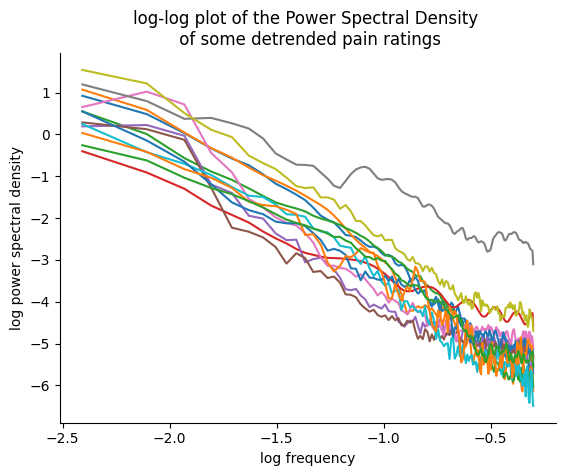

In [511]:
fig, ax = plt.subplots()
for i in range(5):
    for j in range(len(log_freqs_list_all_detrended[i])):
        ax.plot(log_freqs_list_all_detrended[i][j], log_psd_list_all_detrended[i][j])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('log frequency')
ax.set_ylabel('log power spectral density')
ax.set_title('log-log plot of the Power Spectral Density \n of some detrended pain ratings')


(array([ 1.,  0.,  0.,  4., 16., 40., 48., 51., 49., 29.]),
 array([0.73020738, 0.81666886, 0.90313035, 0.98959183, 1.07605332,
        1.1625148 , 1.24897628, 1.33543777, 1.42189925, 1.50836074,
        1.59482222]),
 <BarContainer object of 10 artists>)

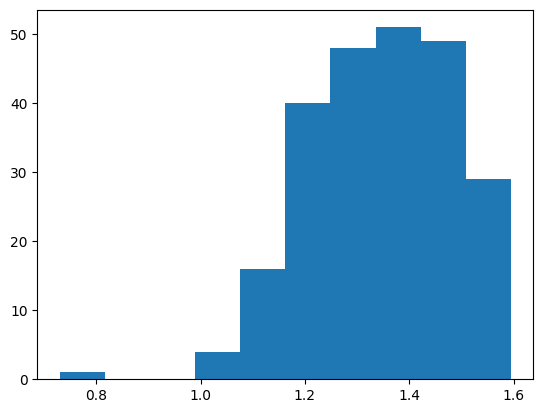

In [344]:
fractal_PSD_all_detrended_flatten = []
for i in range(len(fractal_PSD_all_detrended)):
    for j in range(len(fractal_PSD_all_detrended[i])):
        fractal_PSD_all_detrended_flatten.append(fractal_PSD_all_detrended[i][j])

c:\Users\sharonho\Anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 240, using nperseg = 240
  warnings.warn('nperseg = {0:d} is greater than input length '


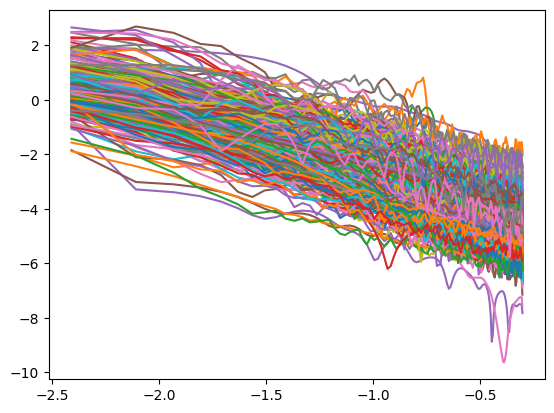

In [328]:
beta_list_all = []
fractal_PSD_all = []
for i in range(len(rating_all)):
    beta = hurst_power_spectrum(rating_all[i])
    beta_list_all.append(beta)
    fractal = 2+np.array(beta)/4
    fractal_PSD_all.append(fractal)

In [487]:
fractal_overall_PSD = []
for i in range(len(fractal_PSD_all)):
    fractal_overall_PSD.append(np.nanmean(fractal_PSD_all[i]))

C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\19494810.py:3: RuntimeWarning: Mean of empty slice
  fractal_overall_PSD.append(np.nanmean(fractal_PSD_all[i]))


In [490]:
index_s1_normal = []
for i in range(len(index_s1)):
    if len(index_s1[i]) == 1:
        index_s1_normal.append(index_s1[i][0])
df_s1_normal = df_questionnaire_s1.iloc[index_s1_normal]
participant_list_s1_questionnaire = df_s1_normal.PROLIFIC_PID.values#.to_list()
s1_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s1_questionnaire:
        s1_questionnaire_index.append(i)
mean_s1 = np.array(mean_overall)[s1_questionnaire_index]
var_s1 = np.array(var_combined_list_all)[s1_questionnaire_index]
fractal_s1_PSD = np.array(fractal_overall_PSD)[s1_questionnaire_index]
index_s2_normal = []
for i in range(len(index_s2)):
    if len(index_s2[i]) == 1:
        index_s2_normal.append(index_s2[i][0])
df_s2_normal = df_questionnaire_s2.iloc[index_s2_normal]
participant_list_s2_questionnaire = df_s2_normal.PROLIFIC_PID.values#.to_list()
s2_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s2_questionnaire:
        s2_questionnaire_index.append(i)
mean_s2 = np.array(mean_overall)[s2_questionnaire_index]
var_s2 = np.array(var_combined_list_all)[s2_questionnaire_index]
fractal_s2_PSD = np.array(fractal_overall_PSD)[s2_questionnaire_index]

[[1.         0.00519107]
 [0.00519107 1.        ]]
0.14159710741329393
[[ 1.         -0.04222706]
 [-0.04222706  1.        ]]
0.15112721884119545
[[ 1.        -0.0804146]
 [-0.0804146  1.       ]]
0.17989776926767082
[[ 1.         -0.04867922]
 [-0.04867922  1.        ]]
0.15609058755473237
[[ 1.         -0.07842522]
 [-0.07842522  1.        ]]
0.17899319437085526
[[1.         0.13969526]
 [0.13969526 1.        ]]
0.27829669920145256
[[1.         0.23446128]
 [0.23446128 1.        ]]
0.7009101306143438
[[ 1.       -0.056283]
 [-0.056283  1.      ]]
0.17497843785463876
[[1.         0.04648039]
 [0.04648039 1.        ]]
0.16653895397894228
[[ 1.         -0.12426113]
 [-0.12426113  1.        ]]
0.24917087104166566
[[ 1.         -0.06905434]
 [-0.06905434  1.        ]]
0.18216266410179124
[[1.         0.09169084]
 [0.09169084 1.        ]]
0.2026293717377321
[[ 1.         -0.06843771]
 [-0.06843771  1.        ]]
0.18069849395860493


Text(0.5, 1.0, 'PHQ9 Score against Fractal Dimension')

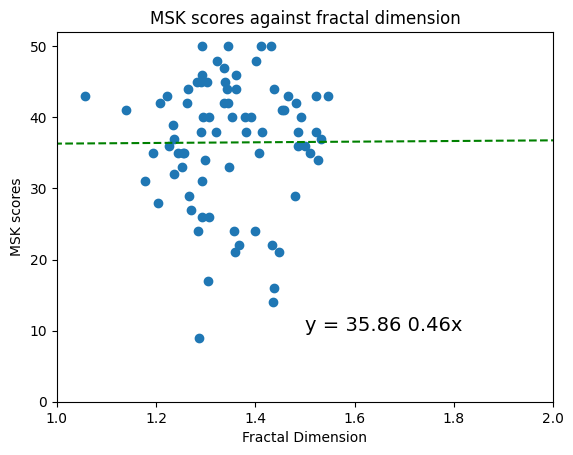

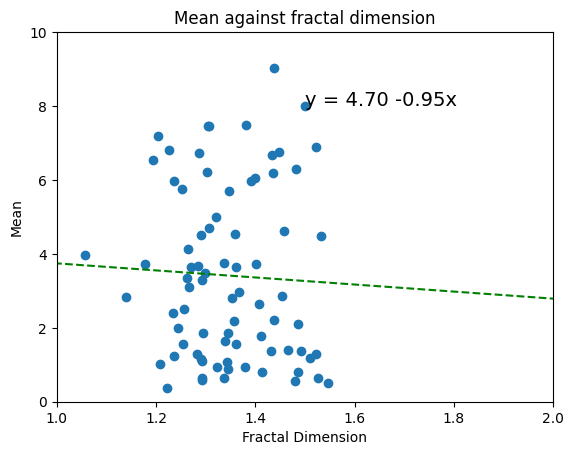

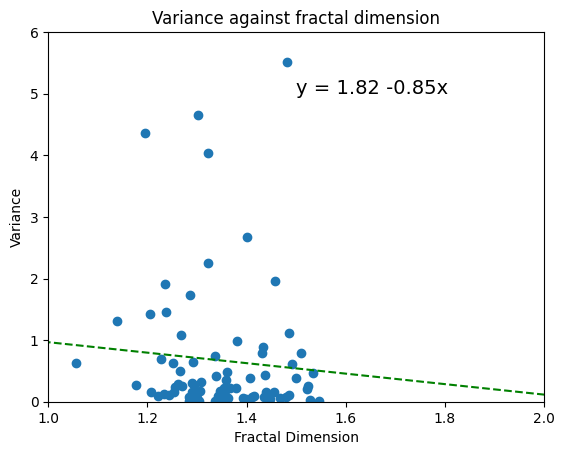

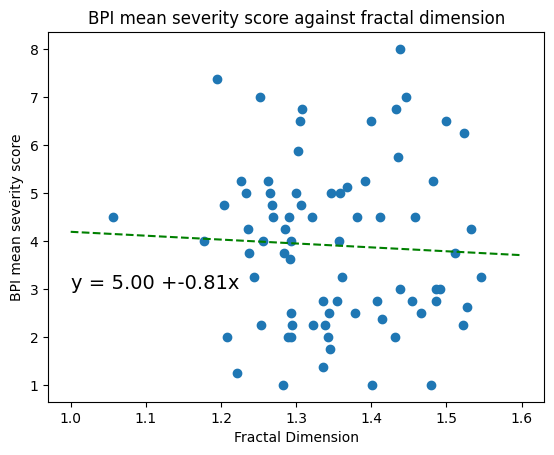

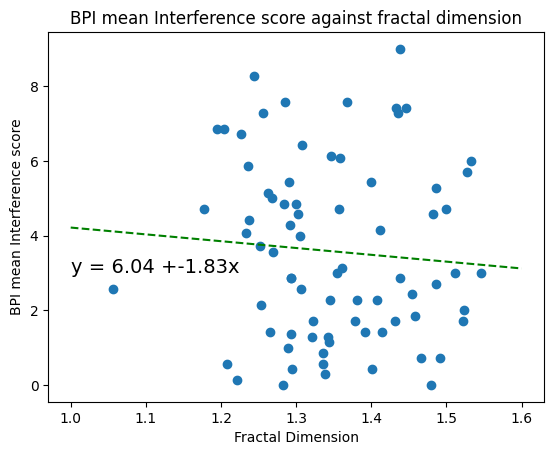

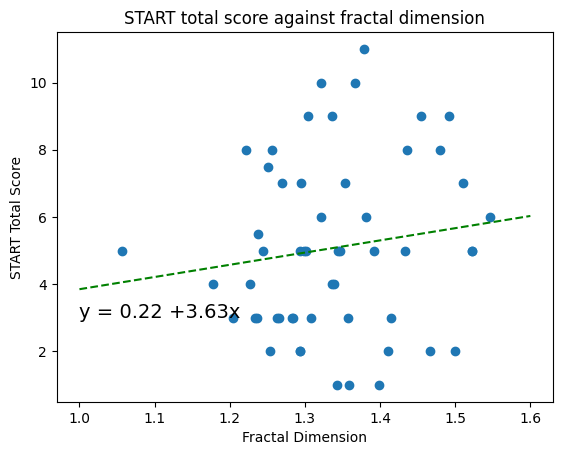

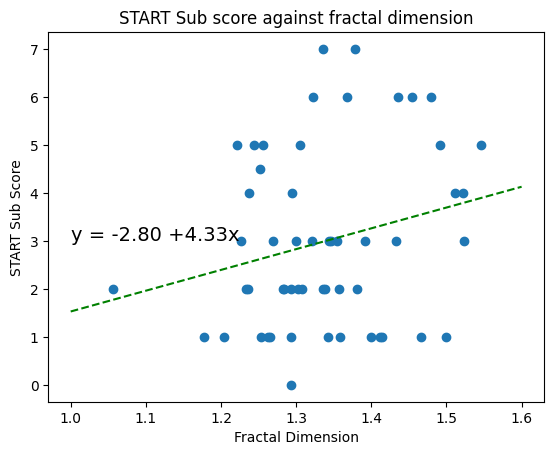

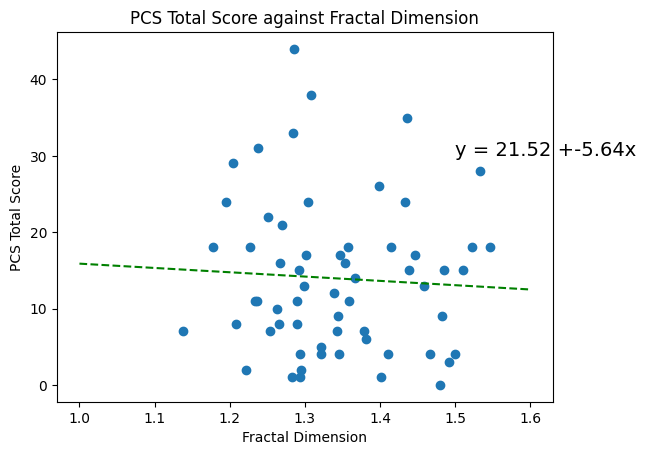

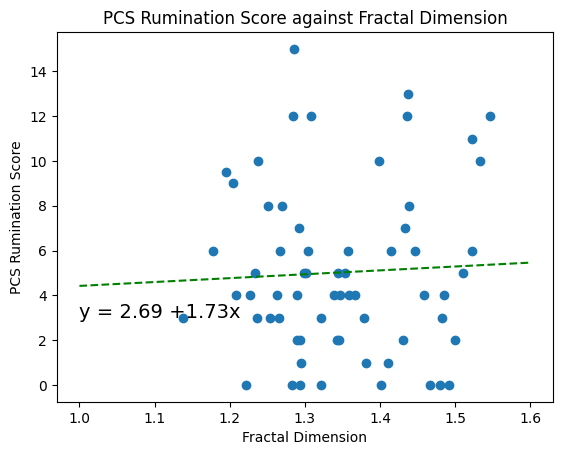

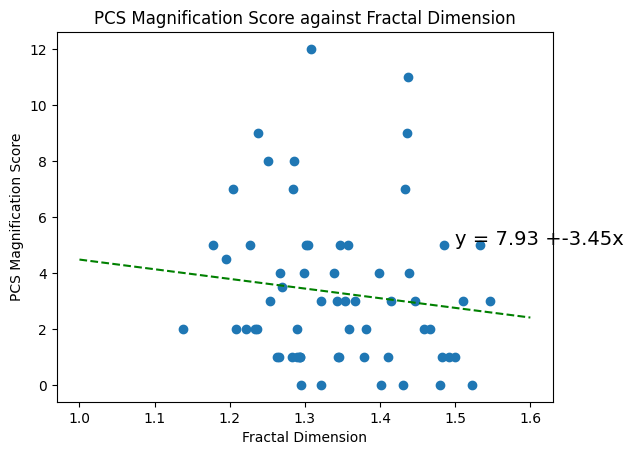

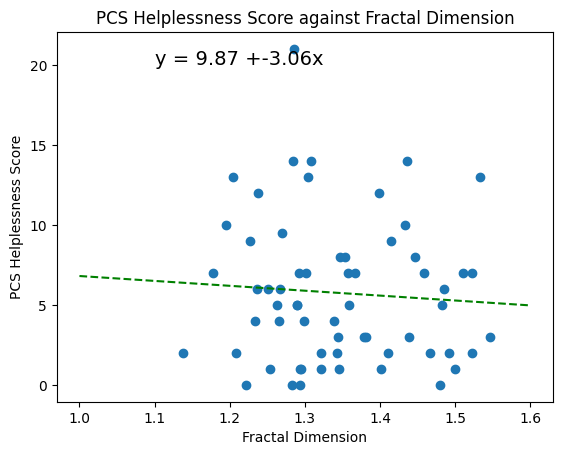

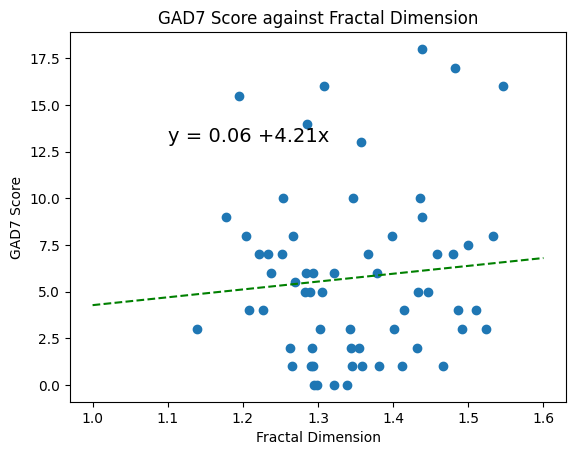

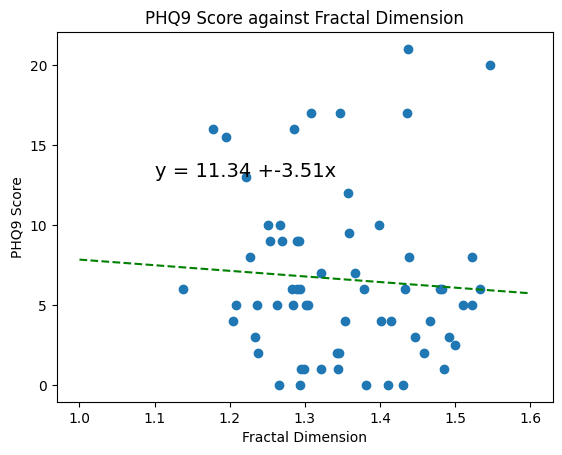

In [491]:
plt.figure()
fractal_mskscores = zip(fractal_overall_PSD, msk_scores)
x = []; y=[]
for point in list(fractal_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores = np.corrcoef(x,y)
print(corr_fractal_mskscores)
fractal_bf_PSD = []
bf_fractal_msk = pingouin.bayesfactor_pearson(corr_fractal_mskscores[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_msk)
print(bf_fractal_msk)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('MSK scores')
plt.xlim(1,2)
plt.ylim(0,52)
plt.text(1.5, 10, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('MSK scores against fractal dimension')


fractal_mean = zip(fractal_overall_PSD, mean_overall)
x = []; y=[]
for point in list(fractal_mean):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mean = np.corrcoef(x,y)
print(corr_fractal_mean)
bf_fractal_mean = pingouin.bayesfactor_pearson(corr_fractal_mean[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_mean)
print(bf_fractal_mean)
plt.figure()
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('Mean')
plt.xlim(1,2)
plt.ylim(0,10)
plt.text(1.5, 8, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('Mean against fractal dimension')

plt.figure()
fractal_var = zip(fractal_overall_PSD, var_combined_list_all)
x = []; y=[]
for point in list(fractal_var):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_var = np.corrcoef(x,y)
print(corr_fractal_var)
bf_fractal_var = pingouin.bayesfactor_pearson(corr_fractal_var[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_var)
print(bf_fractal_var)
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('Variance')
plt.xlim(1,2)
plt.ylim(0,6)
plt.text(1.5, 5, 'y = ' + '{:.2f}'.format(b) + ' {:.2f}'.format(a) + 'x', size=14)
plt.title('Variance against fractal dimension')

plt.figure()
bpi_mean_severity = df_s1_normal['BPI Mean Severity Score'].values
fractal_bpisev = zip(fractal_s1_PSD, bpi_mean_severity)
x = []; y=[]
for point in list(fractal_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpisev = np.corrcoef(x,y)
print(corr_fractal_bpisev)
bf_fractal_bpisev = pingouin.bayesfactor_pearson(corr_fractal_bpisev[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_bpisev)
print(bf_fractal_bpisev)
x_bestfit = np.arange(1,max(fractal_s1_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('BPI mean severity score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('BPI mean severity score against fractal dimension')

plt.figure()
bpi_mean_interference = df_s1_normal['BPI Mean Pain Interference Score'].values
fractal_bpiint = zip(fractal_s1_PSD, bpi_mean_interference)
x = []; y=[]
for point in list(fractal_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpiint = np.corrcoef(x,y)
print(corr_fractal_bpiint)
bf_fractal_bpiint = pingouin.bayesfactor_pearson(corr_fractal_bpiint[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_bpiint)
print(bf_fractal_bpiint)
x_bestfit = np.arange(1,max(fractal_s1_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('BPI mean Interference score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('BPI mean Interference score against fractal dimension')

plt.figure()
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_total = df_s1_normal['START total score'].iloc[back_pain].values
fractal_start = zip(fractal_s1_PSD, start_total)
x = []; y=[]
for point in list(fractal_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_start = np.corrcoef(x,y)
print(corr_fractal_start)
bf_fractal_start = pingouin.bayesfactor_pearson(corr_fractal_start[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_start)
print(bf_fractal_start)
x_bestfit = np.arange(1,max(fractal_s1_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('START Total Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('START total score against fractal dimension')

plt.figure()
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_sub = df_s1_normal['START sub score'].iloc[back_pain].values
fractal_startsub = zip(fractal_s1_PSD, start_sub)
x = []; y=[]
for point in list(fractal_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_startsub = np.corrcoef(x,y)
print(corr_fractal_startsub)
bf_fractal_startsub = pingouin.bayesfactor_pearson(corr_fractal_startsub[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_startsub)
print(bf_fractal_startsub)
x_bestfit = np.arange(1,max(fractal_s1_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('START Sub Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1, 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('START Sub score against fractal dimension')

plt.figure()
pcs_total = df_s2_normal['Total PCS Score'].values
fractal_pcs_total = zip(fractal_s2_PSD, pcs_total)
x = []; y=[]
for point in list(fractal_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_total = np.corrcoef(x,y)
print(corr_fractal_pcs_total)
bf_fractal_pcs_total = pingouin.bayesfactor_pearson(corr_fractal_pcs_total[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_pcs_total)
print(bf_fractal_pcs_total)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Total Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.5, 30, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Total Score against Fractal Dimension')

plt.figure()
pcs_rum = df_s2_normal['PCS Rumination Score'].values
fractal_pcs_rum = zip(fractal_s2_PSD, pcs_rum)
x = []; y=[]
for point in list(fractal_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_rum = np.corrcoef(x,y)
print(corr_fractal_pcs_rum)
bf_fractal_pcs_rum = pingouin.bayesfactor_pearson(corr_fractal_pcs_rum[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_pcs_rum)
print(bf_fractal_pcs_rum)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Rumination Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1., 3, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Rumination Score against Fractal Dimension')

plt.figure()
pcs_mag = df_s2_normal['PCS Magnification Score'].values
fractal_pcs_mag = zip(fractal_s2_PSD, pcs_mag)
x = []; y=[]
for point in list(fractal_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_mag = np.corrcoef(x,y)
print(corr_fractal_pcs_mag)
bf_fractal_pcs_mag = pingouin.bayesfactor_pearson(corr_fractal_pcs_mag[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_pcs_mag)
print(bf_fractal_pcs_mag)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Magnification Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.5, 5, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Magnification Score against Fractal Dimension')

plt.figure()
pcs_help = df_s2_normal['PCS Helplessness Score'].values
fractal_pcs_help = zip(fractal_s2_PSD, pcs_help)
x = []; y=[]
for point in list(fractal_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_help = np.corrcoef(x,y)
print(corr_fractal_pcs_help)
bf_fractal_pcs_help = pingouin.bayesfactor_pearson(corr_fractal_pcs_help[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_pcs_help)
print(bf_fractal_pcs_help)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PCS Helplessness Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.1, 20, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PCS Helplessness Score against Fractal Dimension')

plt.figure()
gad7_total = df_s2_normal['Total GAD7 Score'].values
fractal_gad7 = zip(fractal_s2_PSD, gad7_total)
x = []; y=[]
for point in list(fractal_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_gad7 = np.corrcoef(x,y)
print(corr_fractal_gad7)
bf_fractal_gad7 = pingouin.bayesfactor_pearson(corr_fractal_gad7[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_gad7)
print(bf_fractal_gad7)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('GAD7 Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.1, 13, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('GAD7 Score against Fractal Dimension')

plt.figure()
phq9_total = df_s2_normal['Total PHQ9 Score'].values
fractal_phq9 = zip(fractal_s2_PSD, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
fractal_bf_PSD.append(bf_fractal_phq9)
print(bf_fractal_phq9)
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(1,max(fractal_s2_PSD)+0.1,0.1)
y_bestfit = a*x_bestfit+b
plt.plot(x_bestfit, y_bestfit, color = 'green', linestyle = '--')
plt.scatter(x,y)
plt.xlabel('Fractal Dimension')
plt.ylabel('PHQ9 Score')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.text(1.1, 13, 'y = ' + '{:.2f}'.format(b) + ' +{:.2f}'.format(a) + 'x', size=14)
plt.title('PHQ9 Score against Fractal Dimension')



# Robustness

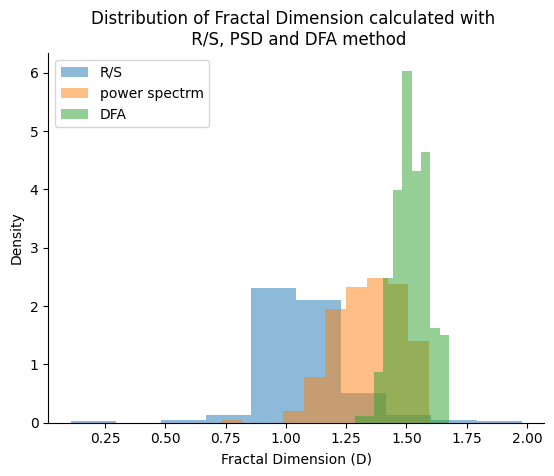

In [512]:
fig, ax = plt.subplots()


ax.hist(fractal_RS_flatten, alpha = 0.5, density = True, label = 'R/S', bins = 10)
ax.hist(fractal_PSD_all_detrended_flatten, alpha = 0.5, density = True, label = 'power spectrm', bins = 10)
ax.hist(fractal_dfa_all_dllm_flatten, alpha = 0.5, density = True, label = 'DFA', bins = 10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Fractal Dimension (D)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Fractal Dimension calculated with \n R/S, PSD and DFA method')
ax.legend()

C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\2370495697.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  detrended_psd_error = np.array(fractal_PSD_all) - np.array(fractal_PSD_all_detrended)


(array([  1.,  13., 223.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-5.32907052e-15, -2.88657986e-15, -4.44089210e-16,  1.99840144e-15,
         4.44089210e-15,  6.88338275e-15,  9.32587341e-15,  1.17683641e-14,
         1.42108547e-14,  1.66533454e-14,  1.90958360e-14]),
 <BarContainer object of 10 artists>)

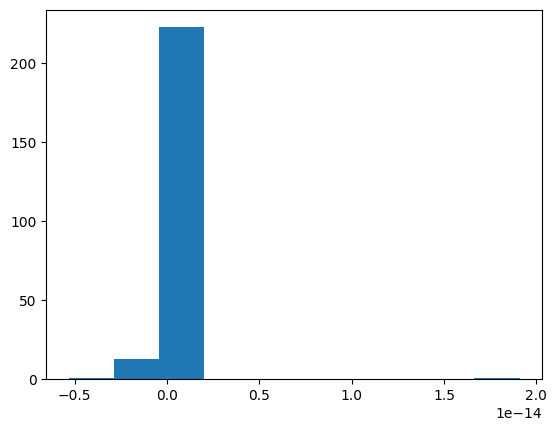

In [343]:
detrended_psd_error = np.array(fractal_PSD_all) - np.array(fractal_PSD_all_detrended)
detrended_psd_error_flatten = []
for i in range(len(detrended_psd_error)):
    for j in range(len(detrended_psd_error[i])):
        detrended_psd_error_flatten.append(detrended_psd_error[i][j])
plt.hist(detrended_psd_error_flatten)

In [291]:
fractal_RS_all

[array([1.02783514, 1.02743566, 1.01468839]),
 array([1.27556932]),
 array([1.05823647, 1.15280711, 1.19838917]),
 array([1.1669216 , 0.99924934, 1.32152316]),
 array([0.98485015,        nan, 0.98158118]),
 array([0.98725191, 1.34047608]),
 array([0.99671932, 1.21742978, 0.94642717]),
 array([0.99445201, 0.64295988, 1.30156336]),
 array([1.26507786, 1.10569849, 1.06064086]),
 array([1.11868394, 1.0384468 , 1.15703079]),
 array([0.78709375, 1.02433824, 0.10690143]),
 array([1.04668307, 1.04101609, 1.08269035]),
 array([1.05846433, 1.03785869, 1.51906611]),
 array([1.12041095, 1.02799984, 1.03451344]),
 array([1.25418593, 1.10360044, 1.15948151]),
 array([1.02257274, 1.07882361, 0.99691024, 1.20406363]),
 array([1.12381696, 0.95218018, 0.99838784]),
 array([], dtype=float64),
 array([1.10030921, 1.22231438, 1.72615218]),
 array([1.12733119, 1.18712662, 1.05284295]),
 array([0.68007349, 1.00246306, 1.0218773 ]),
 array([0.98113659, 0.9866693 , 0.97222761]),
 array([1.02811379, 1.04114884,

In [316]:
diff_method

array([array([-0.03738563, -0.00246845, -0.05828082]),
       array([-0.27022055]),
       array([-0.30807548, -0.25235373, -0.13159005]),
       array([-0.32566986, -0.23204371,  0.17613151]),
       array([-0.33378679,         nan, -0.26280619]),
       array([-0.26010072,  0.09922104]),
       array([-0.26806054, -0.20947848, -0.40242115]),
       array([-0.35039958, -0.67237037, -0.12394393]),
       array([-0.32974437, -0.4236764 , -0.31306953]),
       array([-0.03274329, -0.10016385,  0.03184626]),
       array([-0.75457428, -0.18596314, -1.44002668]),
       array([-0.28544005, -0.30800227, -0.26349245]),
       array([-0.11242489, -0.36293825,  0.32164036]),
       array([-0.38275553, -0.42770081, -0.24892746]),
       array([-0.28596597, -0.40629665, -0.32259914]),
       array([-0.13876259, -0.35448779, -0.14490608, -0.00762179]),
       array([-0.03338175, -0.31060943, -0.28174981]),
       array([], dtype=float64),
       array([-0.35829065, -0.22804376,  0.2348511 ]),
   

In [335]:
diff_method_RS_PSD = np.array(fractal_RS_all) - np.array(fractal_PSD_all)

C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\2986657335.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_method_RS_PSD = np.array(fractal_RS_all) - np.array(fractal_PSD_all)


(array([ 1.,  0.,  1.,  9., 55., 97., 55., 11.,  2.,  2.]),
 array([-1.44002668, -1.22858337, -1.01714006, -0.80569676, -0.59425345,
        -0.38281015, -0.17136684,  0.04007647,  0.25151977,  0.46296308,
         0.67440639]),
 <BarContainer object of 10 artists>)

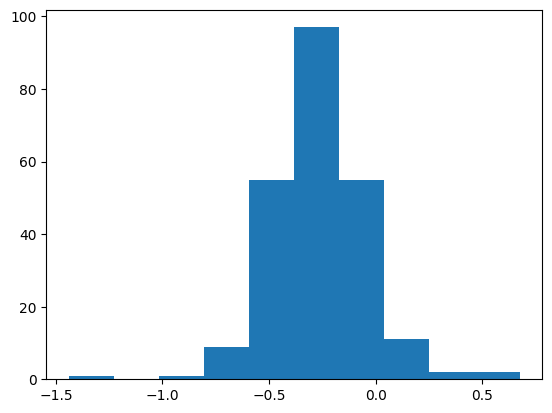

In [336]:
diff_method_flatten_RS_PSD = []
for i in range(len(diff_method_RS_PSD)):
    for j in range(len(diff_method_RS_PSD[i])):
        diff_method_flatten_RS_PSD.append(diff_method_RS_PSD[i][j])
plt.hist(diff_method_flatten_RS_PSD)

In [524]:
diff_method_DFA_PSD = np.array(fractal_dfa_all_dllm) - np.array(fractal_PSD_all)
diff_method_flatten_DFA_PSD = []
for i in range(len(diff_method_DFA_PSD)):
    for j in range(len(diff_method_DFA_PSD[i])):
        diff_method_flatten_DFA_PSD.append(diff_method_DFA_PSD[i][j])

C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\407044167.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_method_DFA_PSD = np.array(fractal_dfa_all_dllm) - np.array(fractal_PSD_all)


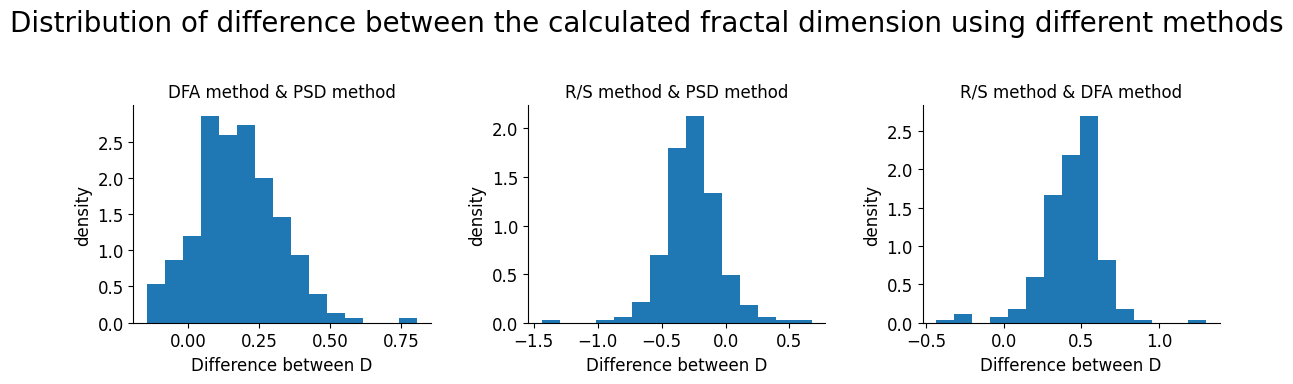

In [547]:

fig, ax = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (12,4)
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels    
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax[0].hist(diff_method_flatten_DFA_PSD, density = True, bins = 15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Difference between D')
ax[0].set_ylabel('density')
ax[0].set_title('DFA method & PSD method')
ax[1].hist(diff_method_flatten_RS_PSD, density = True, bins = 15)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Difference between D')
ax[1].set_ylabel('density')
ax[1].set_title('R/S method & PSD method')
ax[2].hist(diff_method_flatten_DFA_RS, density = True, bins = 15)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('Difference between D')
ax[2].set_ylabel('density')
ax[2].set_title('R/S method & DFA method')
plt.suptitle('Distribution of difference between the calculated fractal dimension using different methods')
plt.tight_layout()

C:\Users\sharonho\AppData\Local\Temp\ipykernel_37212\1880798024.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_method_DFA_RS = np.array(fractal_dfa_all_dllm) - np.array(fractal_RS_all)


(array([  2.,   2.,   5.,  18.,  74., 103.,  27.,   1.,   0.,   1.]),
 array([-0.43578372, -0.26185005, -0.08791637,  0.08601731,  0.25995099,
         0.43388467,  0.60781835,  0.78175203,  0.95568571,  1.12961938,
         1.30355306]),
 <BarContainer object of 10 artists>)

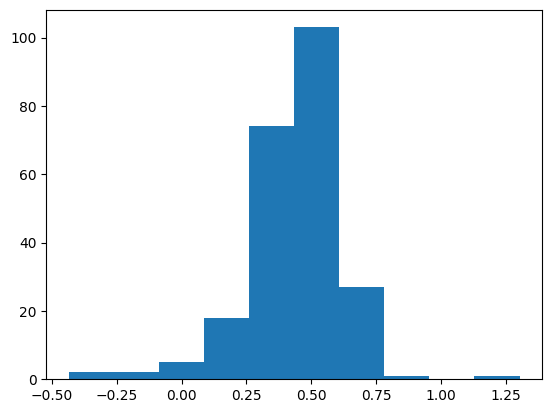

In [452]:
diff_method_DFA_RS = np.array(fractal_dfa_all_dllm) - np.array(fractal_RS_all)
diff_method_flatten_DFA_RS = []
for i in range(len(diff_method_DFA_RS)):
    for j in range(len(diff_method_DFA_RS[i])):
        diff_method_flatten_DFA_RS.append(diff_method_DFA_RS[i][j])
plt.hist(diff_method_flatten_DFA_RS)

In [550]:
print('R/S')
print(np.nanmin(fractal_overall_RS))
print(np.nanmax(fractal_overall_RS))
print(np.nanmean(fractal_overall_RS))
print(np.nanstd(fractal_overall_RS))
print('----------')
print('PSD')
print(np.nanmin(fractal_overall_PSD))
print(np.nanmax(fractal_overall_PSD))
print(np.nanmean(fractal_overall_PSD))
print(np.nanstd(fractal_overall_PSD))
print('----------')
print('DFA')
print(np.nanmin(fractal_dfa_dllm_overall))
print(np.nanmax(fractal_dfa_dllm_overall))
print(np.nanmean(fractal_dfa_dllm_overall))
print(np.nanstd(fractal_dfa_dllm_overall))

R/S
0.6394444717867077
1.5981333782657776
1.079183558211248
0.12661381031507157
----------
PSD
1.056031364332459
1.5457898632602496
1.3473170476192833
0.10237789330094776
----------
DFA
1.4085569397670026
1.5985007148043273
1.5212309580266365
0.04352340751516006
